In [42]:
from glob import glob
import os
import re
import sys
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from collections import Counter
import math


In [43]:
ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd())) # Should be your path to the repo `mint`
sys.path.insert(0, ROOT_DIR)
DATA_DIR = os.path.join(ROOT_DIR, "data", "outputs")
print(f"Data directory: {DATA_DIR}")
glob_pattern = f"{DATA_DIR}/**/*results.jsonl"
filepaths = list(set(glob(glob_pattern, recursive=True)))
print(f"Matching glob pattern: `{glob_pattern}`. **{len(filepaths)}** files found.")


def parse_filepath(filepath):
    # e.g., gpt-3.5-turbo-0613/F=gpt-3.5-turbo-16k-0613/PHF=no_GT-textual/max5_p2+tool+cd/code_generation/humaneval/results.jsonl
    # e.g., gpt-3.5-turbo-0613/F=None/max5_p2+tool+cd/code_generation/humaneval/results.jsonl
    splited = filepath.replace(DATA_DIR, "").lstrip("/").split("/")
    
    agent_model_name = splited[0]
    feedback_model_name = splited[1].split("=")[1]
    if feedback_model_name != "None":
        feedback_setting = splited[2]
    else:
        feedback_setting = "None"
    task_name = splited[-2]
    task_type = splited[-3]
    exp_setting = splited[-4]
    return {
        "agent_model_name": agent_model_name,
        "feedback_model_name": feedback_model_name,
        "feedback_setting": feedback_setting,
        "task_name": task_name,
        "task_type": task_type,
        "exp_setting": exp_setting,
        "filepath": filepath,
    }

df = pd.DataFrame(list(map(parse_filepath, filepaths)))

def load_results(filepath):
    results = []
    with open(filepath) as f:
        for line in f:
            try:
                results.append(json.loads(line))
            except Exception as e:
                print(f"Error loading {filepath}: {e}\n{line}")
                globals()["error_line"] = line
    return pd.DataFrame(results)

df["results"] = df.filepath.apply(load_results)


def rename_model(model_name):
    MODEL_RENAME = {
        "lemur-70b-v1": "Lemur-70b-v1",
        "lemur-70b-chat-v1": "Lemur-70b-chat-v1",
        "llama-2-lemur-70b-chat-v1": "Lemur-70b-chat-v1",
        "llama-2-lemur-70b-v1": "Lemur-70b-v1",
        "agentlm-7b-llama-2": "AgentLM-7b",
        "agentlm-13b-llama-2": "AgentLM-13b",
        "agentlm-70b-llama-2": "AgentLM-70b",
    }
    model_name = MODEL_RENAME.get(model_name, model_name)
    if "-hf" in model_name:
        model_name = model_name.rstrip("-hf")
    return model_name

all_results = []
for row in df.itertuples():
    row.results["agent_model_name"] = rename_model(row.agent_model_name)
    row.results["feedback_model_name"] = rename_model(row.feedback_model_name)
    row.results["feedback_setting"] = row.feedback_setting
    row.results["exp_setting"] = row.exp_setting
    row.results["task_name"] = row.task_name
    row.results["task_type"] = row.task_type
    all_results.append(row.results)


all_results = pd.concat(all_results)
def get_stats(row):
    state = row["state"]
    task = row["task"]
    return {
        "task_id": task["task_id"],
        "n_turns": len(state["history"]) // 2,
        "success": state["success"],
        "agent_action_count": state["agent_action_count"],
        "token_counter": {'a': Counter(state["token_counter"]), 'b': 1},
        "terminate_reason": state["terminate_reason"],
    }


# combine this with the original dataset
stats = all_results.apply(get_stats, axis=1, result_type="expand")
all_results = pd.concat([all_results, stats], axis=1)

# turn bool to int
all_results['success'] = all_results['success'].astype(int)

all_results_unfiltered = all_results.copy()


Data directory: /shared/nas2/xingyao6/projects/mint-bench/data/outputs


In [ ]:
# Sanity check of experiments - check whether they are all completed
all_results_count = all_results.groupby([
    "agent_model_name",
    "feedback_model_name",
    "feedback_setting",
    "exp_setting",
    "task_type",
    "task_name",
])["task_id"]\
.count().unstack().fillna(0)\
.sum(axis=1).unstack().fillna(0).astype(int)

all_results_count.style.background_gradient(cmap='Blues', axis=0)

In [ ]:
# Sanity check of experiments - check whether they are all completed
all_results_count_by_task_name = all_results.groupby([
    "agent_model_name",
    "feedback_model_name",
    "feedback_setting",
    "exp_setting",
    "task_name",
    "task_type",
])["task_id"]\
.count().unstack().fillna(0)\
.sum(axis=1).unstack().fillna(0).astype(int)

all_results_count_by_task_name.style.background_gradient(cmap='Blues', axis=0)


# Utils

In [ ]:
def generate_table(
    query, mode = 'sr', return_raw = False,
    consider_exceed_context = False,
    by_task_name = False,
    all_results = all_results
):
    results = all_results.query(query)
    n_invalid_actions = results['agent_action_count'].apply(lambda x: x['invalid_action'])
    n_turns = results['n_turns']
    n_error = results['agent_action_count'].apply(lambda x: x.get('error', 0))

    results = results.assign(
        n_invalid_actions=n_invalid_actions,
        n_turns=n_turns,
        n_error=n_error,
    )
    if consider_exceed_context:
        results["final_length_exceeds_4096"] = results["final_length_exceeds_4096"].fillna(False)
        results["success"] = results.apply(lambda row: int(row["success"] and not row["final_length_exceeds_4096"]), axis=1)

    results_raw = results.copy()
    # draw a table with the performance on four tasks as the horizontal axis and the micro mean success rate and different models as the vertical axis. display it with seaborn
    # firstly calculate micro mean
    if mode == 'sr':
        micro_sr = results.groupby("agent_model_name")['success'].mean()
        if by_task_name:
            results_sr = results.groupby(["agent_model_name", "task_name"])['success'].mean().unstack()
        else:
            results_sr = results.groupby(["agent_model_name", "task_type"])['success'].mean().unstack()
        results_sr['avg_micro'] = micro_sr
        results = (results_sr * 100).round(2)
    elif mode == "invalid_count":
        micro_invalid_count = results.groupby("agent_model_name")['n_invalid_actions'].mean()
        results_invalid_count = results.groupby(["agent_model_name", "task_type"])['n_invalid_actions'].mean().unstack()
        results_invalid_count['avg_micro'] = micro_invalid_count

        micro_n_turns = results.groupby("agent_model_name")['n_turns'].mean()
        results_n_turns = results.groupby(["agent_model_name", "task_type"])['n_turns'].mean().unstack()
        results_n_turns['avg_micro'] = micro_n_turns

        micro_n_error = results.groupby("agent_model_name")['n_error'].mean()
        results_n_error = results.groupby(["agent_model_name", "task_type"])['n_error'].mean().unstack()
        results_n_error['avg_micro'] = micro_n_error

        results = pd.concat(
            [results_invalid_count, results_n_turns, results_n_error],
            axis=1,
            keys=["invalid_count", "n_turns", "n_error"]
        ).round(2)
    else:
        raise ValueError(f"Unknown mode: {mode}")
    if return_raw:
        return results, results_raw
    else:
        return results



NAME_REGEX_TO_VARIANT = [
    # NOTE: the order matters - the first match will be used
    ("AgentLM.*", "2SIFT"),
    ("CodeLlama.*Instruct.*", "2SIFT"),
    ("CodeLlama.*", "1Base"),
    ("Lemur.*chat.*", "2SIFT"),
    ("Lemur.*", "1Base"),
    ("Llama-2.*chat.*", "3RLHF"),
    ("Llama-2.*", "1Base"),
    ("MAmmoTH.*", "2SIFT"),
    ("Magicoder.*", "2SIFT"),
    ("Mistral.*Instruct.*", "2SIFT"),
    ("Mistral.*", "1Base"),
    ("Mixtral.*Instruct.*", "2SIFT"),
    ("OpenCodeInterpreter.*", "2SIFT"),
    ("OpenMath.*", "2SIFT"),
    ("Starling.*", "3RLHF"),
    ("WizardMath.*", "3RLHF"),
    ("chat-bison.*", "3RLHF"),
    ("claude.*", "3RLHF"),
    ("deepseek-coder.*", "2SIFT"),
    ("deepseek-llm.*chat", "2SIFT"),
    ("gpt-3.5-turbo.*", "3RLHF"),
    ("gpt-4.*", "3RLHF"),
    ("openchat-3.5.*", "2SIFT"),
    ("vicuna.*", "2SIFT"),
    ("zephyr.*", "3RLHF"),
    ("CodeActAgent.*", "2SIFT"),
    ("Eurus.*SFT", "2SIFT"),
    ("Eurus.*", "3RLHF"),
    ("Qwen.*Chat", "3RLHF"),
    ("CodeQwen.*Chat", "2SIFT"),
    ("CodeQwen.*Chat", "2SIFT"),
    ("Meta-Llama-3.*Instruct", "3RLHF")
]

def parse_modelname(name):
    if "gpt" in name or "claude" in name or "bison" in name:
        name = r"\texttt{" + name + "}"
        return {"model": name, "size": "-", "type": "-"}

    import re
    # size = float(re.search(r'(\d+)b', name.lower()).group(1))
    # expect size to be float too
    size = re.search(r'(\d+\.?\d*)b', name.lower())
    # make size a float
    size = float(size.group(1)) if size else None
    if size is None:
        size = "-"
    elif int(size) == size:
        size = str(int(size))
    else:
        size = str(size)
    if "openchat" in name:
        size = "7"

    model_variant = "1Base"

    for regex, variant in NAME_REGEX_TO_VARIANT:
        if re.match(regex, name):
            model_variant = variant
            break
            
    model_name = name
    # if "Llama-2" in name:
    #     model_name = "LLaMA-2"
    # elif "Lemur" in name and "v1" in name:
    #     model_name = "Lemur-v1"
    # elif "Mistral" in name and "v0.1" in name:
    #     # Mistral-7B-Instruct-v0.1
    #     model_name = "Mistral-v0.1"
    # elif "vicuna" in name and "v1.5" in name:
    #     if "-16k" in name:
    #         model_name = "Vicuna-v1.5-16k"
    #     else:
    #         model_name = "Vicuna-v1.5"
    # else:
    #     model_name = name.split("-")[0]
    # model_name = r"\texttt{" + model_name + "}"
    return {
        "model": model_name,
        "size": size,
        "type": model_variant
    }

def is_filtered_model(model_name):
    # do not print 16k models
    FILTER_MODEL_NAMES = [
        "gpt-3.5-turbo-16k-0613",
    ]
    # or "CodeLlama" in model_name \
    if model_name in FILTER_MODEL_NAMES \
        or ("vicuna" in model_name and "16k" in model_name):
        return True
    return False


# Combine results
def get_interaction_turns(**kwargs):
    interaction_turns = []
    for setting in ['max1_p1+tool+cd', 'max2_p2+tool+cd', 'max3_p2+tool+cd', 'max4_p2+tool+cd', 'max5_p2+tool+cd']:
        _cur_table, _cur_table_raw = generate_table(
            f"exp_setting == '{setting}' and feedback_setting == 'None' and feedback_model_name == 'None'",
            mode="sr",
            return_raw=True,
            **kwargs
        )
        _cur_table = _cur_table.unstack().to_frame().rename(columns={0: 'success_rate'}).reset_index()
        cur_turn = int(re.search(r'max(\d+)_', setting).group(1))
        _cur_table['n_turns'] = cur_turn
        interaction_turns.append(_cur_table)
        _turn_vs_success = _cur_table_raw[["agent_model_name", "success"]]
        _turn_vs_success = _turn_vs_success.assign(n_turns=cur_turn)

    interaction_turns = pd.concat(interaction_turns)
    return interaction_turns


def run_regression_on_row(series):
    if not len(series.dropna()):
        print(series)
        return {}
    x = list(series.index)
    y = series.values
    _df = pd.DataFrame({"x": x, "y": y})
    model = sm.ols(formula='y ~ x', data=_df)
    results = model.fit()
    return {
        **{k: v for k, v in results.params.to_dict().items()},
        "rsquared": results.rsquared,
        # "pvalues": results.pvalues.to_dict()
        **{f"pvalue_{k}": v for k, v in results.pvalues.to_dict().items()}
    }

# Code / Math Subset

As used in [Eurus paper](https://arxiv.org/abs/2404.02078).

In [ ]:
EURUS_SELECTED_TASKS = {
    # reasoning / math
    "theoremqa", "mmlu", "math",
    # "gsm8k", 
    
    # code
    "mbpp", "humaneval"    
}
eurus_subset_results = all_results[all_results.task_name.isin(EURUS_SELECTED_TASKS)]

In [ ]:
# Sanity check of experiments - check whether they are all completed
eurus_results_count = eurus_subset_results.groupby([
    "agent_model_name",
    "feedback_model_name",
    "feedback_setting",
    "exp_setting",
    "task_type",
    "task_name",
])["task_id"]\
.count().unstack().fillna(0)\
.sum(axis=1).unstack().fillna(0).astype(int)
# eurus_results_count.style.background_gradient(cmap='Blues', axis=0)

In [ ]:
# Filter out experiments that are not completed

# find all index that are not [136, 134, 320]
EURUS_GLOBAL_MAX = eurus_results_count.max()
# assert (GLOBAL_MAX == pd.Series([136, 273], index=["code_generation", "reasoning"])).all()
assert (EURUS_GLOBAL_MAX == pd.Series([136, 225], index=["code_generation", "reasoning"])).all()
def _exp_completed(row):
    return (row == EURUS_GLOBAL_MAX).all()

eurus_completed_exp = eurus_results_count.apply(_exp_completed, axis=1)
# select only completed exp
eurus_completed_exp = eurus_completed_exp.drop(eurus_completed_exp[eurus_completed_exp == False].index)
# display(completed_exp.to_frame().style.background_gradient(cmap='Blues', axis=0))
eurus_completed_exp_lst = set(map(tuple, eurus_completed_exp.reset_index().drop(columns=[0]).to_numpy().tolist()))
# agent_model_name	feedback_model_name	feedback_setting	exp_setting
# completed_exp_lst
eurus_completed_mask = eurus_subset_results.apply(
    lambda row: (row["agent_model_name"], row["feedback_model_name"], row["feedback_setting"], row["exp_setting"]) in eurus_completed_exp_lst,
    axis=1
)
print(f"Before filtering: {len(eurus_subset_results)}")
eurus_not_completed = eurus_subset_results[~eurus_completed_mask]
eurus_subset_results = eurus_subset_results[eurus_completed_mask]
print(f"After filtering: {len(eurus_subset_results)}")

Before filtering: 111910
After filtering: 111910


In [ ]:
# For models where > 50% of the conversations contain Python tags, we switch to branch #parse-python-code-block for evaluation

# eurus_subset_results["python_tag_exist"] = eurus_subset_results["state"].apply(lambda x: sum([m["content"].count("```") for m in x["history"] if m["role"] == "assistant"]) >= 1)
# _python_tag_analysis_by_model = eurus_subset_results.query("exp_setting == 'max5_p2+tool+cd'")\
#     .groupby(["agent_model_name", "feedback_model_name", "feedback_setting", "exp_setting"])["python_tag_exist"].agg(["sum", "count"])\
# _python_tag_analysis_by_model["ratio"] = _python_tag_analysis_by_model["sum"] / _python_tag_analysis_by_model["count"]
# _python_tag_analysis_by_model.sort_values("ratio", ascending=False).style.format("{:.2%}", subset=["ratio"]).set_caption("Python tag existence ratio by model")\
#     .background_gradient(cmap='viridis', subset=["ratio"])

In [ ]:
print("SR")
eurus_main_table_sr = generate_table(
    "exp_setting == 'max5_p2+tool+cd' and feedback_setting == 'None' and feedback_model_name == 'None'", mode="sr",
    all_results=eurus_subset_results
)
display(eurus_main_table_sr.sort_values(by="avg_micro", ascending=False).style.format("{:.2f}").background_gradient(cmap='Blues', axis=1))

SR


task_type,code_generation,reasoning,avg_micro
agent_model_name,,,
gpt-4-0613,59.56,65.78,63.43
Meta-Llama-3-70B-Instruct,50.00,64.89,59.28
Eurus-70B-KTO,38.97,49.78,45.71
claude-2,36.76,46.22,42.66
claude-instant-1,35.29,42.67,39.89
Eurus-70B-NCA,38.24,39.56,39.06
deepseek-llm-67b-chat,30.88,41.78,37.67
gpt-3.5-turbo-16k-0613,30.88,41.33,37.40
Eurus-70B-SFT,31.62,40.44,37.12


In [ ]:
eurus_interaction_turns = get_interaction_turns(all_results=eurus_subset_results)
eurus_interaction_turns = eurus_interaction_turns[~eurus_interaction_turns.agent_model_name.map(is_filtered_model)]
eurus_interaction_turns

,task_type,agent_model_name,success_rate,n_turns
0,code_generation,AgentLM-13b,2.21,1
1,code_generation,AgentLM-70b,2.21,1
2,code_generation,AgentLM-7b,0.00,1
3,code_generation,CodeActAgent-Llama-2-7b,2.21,1
4,code_generation,CodeActAgent-Mistral-7b-v0.1,5.88,1
...,...,...,...,...
157,avg_micro,gpt-4-0613,63.43,5
158,avg_micro,openchat-3.5-1210,28.25,5
159,avg_micro,vicuna-13b-v1.5,7.48,5
160,avg_micro,vicuna-7b-v1.5,7.20,5


In [ ]:
KEY = "avg_micro"
_view = eurus_interaction_turns.set_index(['agent_model_name', 'n_turns', 'task_type']).unstack() \
    .sort_index()["success_rate"][[KEY]].unstack()
_view = pd.concat([_view[KEY], _view[KEY].apply(run_regression_on_row, axis=1, result_type='expand')], axis=1)
_view = pd.concat([pd.DataFrame(_view.reset_index()["agent_model_name"].apply(parse_modelname).tolist()), _view.reset_index()], axis=1)
_view["model"] = _view["model"].apply(lambda x: x.replace("\\texttt{", "").replace("}", ""))
_view.set_index(["model", "size", "type"], inplace=True)
_view.drop(columns=["agent_model_name"], inplace=True)
_view.sort_index(inplace=True)
_view.index = _view.index.map(lambda x: (x[0], f"{x[1]}B" if x[1] != "-" else "-", x[2].replace('1', '').replace('2', '').replace('3', '')))
print(f"====== {KEY} ======")
_view.sort_values(by=5, ascending=False).style.format("{:.2f}").background_gradient(cmap='Blues', axis=0).set_caption(f"Success rate by model ({KEY})")

====== avg_micro ======


/home/xingyao6/opt/miniconda3/envs/mint/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/xingyao6/opt/miniconda3/envs/mint/lib/python3.9/site-packages/pandas/io/formats/style.py:3559: RuntimeWarning: invalid value encountered in scalar multiply
  norm = mpl.colors.Normalize(smin - (rng * low), smax + (rng * high))


,,,1,2,3,4,5,Intercept,x,rsquared,pvalue_Intercept,pvalue_x
model,size,type,,,,,,,,,,
gpt-4-0613,-,-,nan,nan,nan,nan,63.43,2.44,12.20,-inf,nan,nan
Meta-Llama-3-70B-Instruct,70B,RLHF,40.44,47.92,55.68,58.45,59.28,37.89,4.82,0.90,0.00,0.01
Eurus-70B-KTO,70B,RLHF,18.28,36.01,41.83,43.77,45.71,18.33,6.26,0.79,0.06,0.04
claude-2,-,-,28.81,41.55,39.89,44.88,42.66,30.25,3.10,0.61,0.01,0.12
claude-instant-1,-,-,10.25,32.96,39.61,43.21,39.89,12.32,6.95,0.68,0.27,0.09
Eurus-70B-NCA,70B,RLHF,5.54,29.36,35.46,39.89,39.06,6.59,7.76,0.74,0.50,0.06
deepseek-llm-67b-chat,67B,SIFT,5.26,30.19,37.95,39.06,37.67,7.92,7.37,0.67,0.49,0.09
Eurus-70B-SFT,70B,SIFT,1.11,29.64,36.01,40.72,37.12,3.99,8.31,0.67,0.74,0.09
Eurus-7B-KTO,7B,RLHF,13.30,27.70,29.36,30.75,34.35,13.55,4.52,0.78,0.06,0.05


In [ ]:
def index_to_dict(index):
    model_name, size, model_type = index
    model_name = model_name.replace(r"\texttt{", "").replace("}", "")
    # remove $..$ for model_type
    model_type = re.sub(r"\$.*?\$", "", model_type)

    # if size == "-":
    #     name = f"{model_name} (closed-source)"
    # else:
    #     if "B" not in str(size):
    #         size = f"{size}B"
    #     name = f"{model_name} ({size}, {model_type})"
    # return name
    return {
        "model": model_name,
        "size": size,
        "type": model_type
    }

def save_website_json_eurus(view, filename):
    d = []
    for row in view[[1, 2, 3, 4, 5, "x"]].iterrows():
        info = index_to_dict(row[0])
        # if "gpt-4" in info["model"]: 
        #     print(row[1].values.tolist())
        #     continue
        data = row[1].values.tolist()
        data = [x if not math.isnan(x) else "-" for x in data]

        d.append({
            **info,
            "1": data[0],
            "2": data[1],
            "3": data[2],
            "4": data[3],
            "5": data[4],
            "Slope": f"{data[5]:.1f}",
        })
    with open(filename, "w") as f:
        json.dump(d, f, indent=2)

In [ ]:
KEY = "code_generation"
_view = eurus_interaction_turns.set_index(['agent_model_name', 'n_turns', 'task_type']).unstack() \
    .sort_index()["success_rate"][[KEY]].unstack()
_view = pd.concat([_view[KEY], _view[KEY].apply(run_regression_on_row, axis=1, result_type='expand')], axis=1)
_view = pd.concat([pd.DataFrame(_view.reset_index()["agent_model_name"].apply(parse_modelname).tolist()), _view.reset_index()], axis=1)
_view["model"] = _view["model"].apply(lambda x: x.replace("\\texttt{", "").replace("}", ""))
_view.set_index(["model", "size", "type"], inplace=True)
_view.drop(columns=["agent_model_name"], inplace=True)
_view.sort_index(inplace=True)
_view.index = _view.index.map(lambda x: (x[0], f"{x[1]}B" if x[1] != "-" else "-", x[2].replace('1', '').replace('2', '').replace('3', '')))
print(f"====== {KEY} ======")
save_website_json_eurus(_view, "../../website/data/eurus_code_sr_vs_k_series.json")
_view.sort_values(by=5, ascending=False).style.format("{:.2f}").background_gradient(cmap='Blues', axis=0).set_caption(f"Success rate by model ({KEY})")

/home/xingyao6/opt/miniconda3/envs/mint/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/xingyao6/opt/miniconda3/envs/mint/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


====== code_generation ======


/home/xingyao6/opt/miniconda3/envs/mint/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/xingyao6/opt/miniconda3/envs/mint/lib/python3.9/site-packages/pandas/io/formats/style.py:3559: RuntimeWarning: invalid value encountered in scalar multiply
  norm = mpl.colors.Normalize(smin - (rng * low), smax + (rng * high))


,,,1,2,3,4,5,Intercept,x,rsquared,pvalue_Intercept,pvalue_x
model,size,type,,,,,,,,,,
gpt-4-0613,-,-,nan,nan,nan,nan,59.56,2.29,11.45,-inf,nan,nan
Meta-Llama-3-70B-Instruct,70B,RLHF,35.29,40.44,47.79,50.74,50.00,32.94,3.97,0.87,0.00,0.02
CodeQwen1.5-7B-Chat,7B,SIFT,0.00,41.18,44.85,49.26,47.79,5.52,10.37,0.63,0.74,0.11
Eurus-70B-KTO,70B,RLHF,30.15,37.50,38.97,39.71,38.97,31.10,1.99,0.63,0.00,0.11
Eurus-70B-NCA,70B,RLHF,5.15,27.94,33.82,37.50,38.24,5.81,7.57,0.77,0.52,0.05
claude-2,-,-,24.26,33.09,31.62,36.76,36.76,23.90,2.87,0.78,0.00,0.05
deepseek-coder-33b-instruct,33B,SIFT,3.68,36.03,33.82,35.29,35.29,10.08,6.25,0.49,0.47,0.19
claude-instant-1,-,-,4.41,27.94,33.09,35.29,35.29,6.47,6.91,0.70,0.51,0.08
Eurus-70B-SFT,70B,SIFT,0.00,29.41,31.62,35.29,31.62,4.85,6.91,0.57,0.70,0.14


In [ ]:
KEY = "reasoning"  # This is the Math subset used in Eurus
_view = eurus_interaction_turns.set_index(['agent_model_name', 'n_turns', 'task_type']).unstack() \
    .sort_index()["success_rate"][[KEY]].unstack()
_view = pd.concat([_view[KEY], _view[KEY].apply(run_regression_on_row, axis=1, result_type='expand')], axis=1)
_view = pd.concat([pd.DataFrame(_view.reset_index()["agent_model_name"].apply(parse_modelname).tolist()), _view.reset_index()], axis=1)
_view["model"] = _view["model"].apply(lambda x: x.replace("\\texttt{", "").replace("}", ""))
_view.set_index(["model", "size", "type"], inplace=True)
_view.drop(columns=["agent_model_name"], inplace=True)
_view.sort_index(inplace=True)
_view.index = _view.index.map(lambda x: (x[0], f"{x[1]}B" if x[1] != "-" else "-", x[2].replace('1', '').replace('2', '').replace('3', '')))
print(f"====== {KEY} ======")
save_website_json_eurus(_view, "../../website/data/eurus_math_sr_vs_k_series.json")
_view.sort_values(by=5, ascending=False).style.format("{:.2f}").background_gradient(cmap='Blues', axis=0).set_caption(f"Success rate by model ({KEY})")

====== reasoning ======


/home/xingyao6/opt/miniconda3/envs/mint/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/xingyao6/opt/miniconda3/envs/mint/lib/python3.9/site-packages/pandas/io/formats/style.py:3559: RuntimeWarning: invalid value encountered in scalar multiply
  norm = mpl.colors.Normalize(smin - (rng * low), smax + (rng * high))


,,,1,2,3,4,5,Intercept,x,rsquared,pvalue_Intercept,pvalue_x
model,size,type,,,,,,,,,,
gpt-4-0613,-,-,nan,nan,nan,nan,65.78,2.53,12.65,-inf,nan,nan
Meta-Llama-3-70B-Instruct,70B,RLHF,43.56,52.44,60.44,63.11,64.89,40.89,5.33,0.91,0.00,0.01
Eurus-70B-KTO,70B,RLHF,11.11,35.11,43.56,46.22,49.78,10.62,8.84,0.81,0.29,0.04
claude-2,-,-,31.56,46.67,44.89,49.78,46.22,34.09,3.24,0.52,0.01,0.17
Eurus-7B-KTO,7B,RLHF,10.22,31.56,36.44,38.22,43.56,10.00,7.33,0.81,0.24,0.04
claude-instant-1,-,-,13.78,36.00,43.56,48.00,42.67,15.87,6.98,0.66,0.20,0.09
deepseek-llm-67b-chat,67B,SIFT,8.44,31.56,41.33,40.00,41.78,10.09,7.51,0.71,0.36,0.08
Eurus-70B-SFT,70B,SIFT,1.78,29.78,38.67,44.00,40.44,3.47,9.15,0.71,0.77,0.07
Eurus-70B-NCA,70B,RLHF,5.78,30.22,36.44,41.33,39.56,7.06,7.87,0.73,0.49,0.06


# Results in Original MINT Paper

In [ ]:
# Filter out experiments that are not completed

# find all index that are not [136, 134, 320]
GLOBAL_MAX = all_results_count.max()
assert (GLOBAL_MAX == pd.Series([136, 134, 316], index=["code_generation", "decision_making", "reasoning"])).all()
def _exp_completed(row):
    return (row == GLOBAL_MAX).all()

completed_exp = all_results_count.apply(_exp_completed, axis=1)
# select only completed exp
completed_exp = completed_exp.drop(completed_exp[completed_exp == False].index)#.reset_index().drop(columns=[0])
# display(completed_exp.to_frame().style.background_gradient(cmap='Blues', axis=0))

completed_exp_lst = set(map(tuple, completed_exp.reset_index().drop(columns=[0]).to_numpy().tolist()))
# agent_model_name	feedback_model_name	feedback_setting	exp_setting
# completed_exp_lst
_completed_mask = all_results.apply(lambda row: (row["agent_model_name"], row["feedback_model_name"], row["feedback_setting"], row["exp_setting"]) in completed_exp_lst, axis=1)
print(f"Before filtering: {len(all_results)}")
not_completed = all_results[~_completed_mask]
all_results = all_results[_completed_mask]
print(f"After filtering: {len(all_results)}")


Before filtering: 179005
After filtering: 172870


In [ ]:
_n = not_completed.groupby(["agent_model_name", "feedback_model_name", "feedback_setting", "exp_setting", "task_type"])["task_id"].count().reset_index()[["agent_model_name", "feedback_model_name", "feedback_setting", "exp_setting", "task_type"]]

# only print agent_model_name & feedback_model_name that are not completed
_n[["agent_model_name", "feedback_model_name", "exp_setting"]].drop_duplicates()


,agent_model_name,feedback_model_name,exp_setting
0,Eurus-70B-KTO,None,max1_p1+tool+cd
2,Eurus-70B-KTO,None,max2_p2+tool+cd
4,Eurus-70B-KTO,None,max3_p2+tool+cd
6,Eurus-70B-KTO,None,max4_p2+tool+cd
8,Eurus-70B-KTO,None,max5_p2+tool+cd
10,Eurus-7B-DPO,None,max1_p1+tool+cd
12,Eurus-7B-DPO,None,max2_p2+tool+cd
14,Eurus-7B-DPO,None,max3_p2+tool+cd
16,Eurus-7B-DPO,None,max4_p2+tool+cd
18,Eurus-7B-DPO,None,max5_p2+tool+cd


In [ ]:
FILTERED_MODELS =[
    # TODO(user): fill in models you want to filter out
]
all_results = all_results[~all_results["agent_model_name"].isin(FILTERED_MODELS)]


In [ ]:
sorted(list(all_results["agent_model_name"].unique()))


['AgentLM-13b',
 'AgentLM-70b',
 'AgentLM-7b',
 'CodeActAgent-Llama-2-7b',
 'CodeActAgent-Mistral-7b-v0.1',
 'CodeLlama-13b',
 'CodeLlama-13b-Instruct',
 'CodeLlama-34b',
 'CodeLlama-34b-Instruct',
 'CodeLlama-70b-Instruct',
 'CodeLlama-7b',
 'CodeLlama-7b-Instruct',
 'CodeQwen1.5-7B-Chat',
 'Eurus-70B-NCA',
 'Eurus-70B-SFT',
 'Eurus-7B-KTO',
 'Eurus-7B-SFT',
 'Lemur-70b-chat-v1',
 'Lemur-70b-v1',
 'Llama-2-13b',
 'Llama-2-13b-chat',
 'Llama-2-70b',
 'Llama-2-70b-chat',
 'Llama-2-7b',
 'Llama-2-7b-chat',
 'MAmmoTH-7B-Mistral',
 'Magicoder-S-DS-6.7B',
 'Meta-Llama-3-70B-Instruct',
 'Mistral-7B-Instruct-v0.1',
 'Mistral-7B-Instruct-v0.2',
 'Mistral-7B-v0.1',
 'Mixtral-8x7B-Instruct-v0.1',
 'OpenCodeInterpreter-CL-70B',
 'OpenCodeInterpreter-DS-6.7B',
 'OpenMath-CodeLlama-70b-Python',
 'OpenMath-Mistral-7B-v0.1',
 'Qwen1.5-72B-Chat',
 'Starling-LM-7B-alpha',
 'WizardMath-7B-V1.1',
 'chat-bison-001',
 'claude-2',
 'claude-instant-1',
 'deepseek-coder-33b-instruct',
 'deepseek-llm-67b-chat'

# Results

## Success Rate @ k=5

In [ ]:
print("SR")
main_table_sr = generate_table(
    "exp_setting == 'max5_p2+tool+cd' and feedback_setting == 'None' and feedback_model_name == 'None'", mode="sr"
)
display(main_table_sr.sort_values(by="avg_micro").style.format("{:.2f}").background_gradient(cmap='Blues', axis=1))

# === Check performance difference if we consider CodeLLaMA exceed 4096 token to be wrong (for LLaMA2 fair comparison) ===
# main_table_sr_consider_context = generate_table("exp_setting == 'max5_p2+tool+cd' and feedback_setting == 'None' and feedback_model_name == 'None'", mode="sr", consider_exceed_context=True, display_table=False)
# display(main_table_sr_consider_context.style.format("{:.2f}").background_gradient(cmap='Blues', axis=1))
# # Make sure there is no larger than 4096
# pd.concat([main_table_sr, main_table_sr_consider_context], axis=1, keys=["SR", "SR (consider exceed context)"]).swaplevel(axis=1).sort_index(axis=1).style.format("{:.2f}").background_gradient(cmap='Blues')


SR


task_type,code_generation,decision_making,reasoning,avg_micro
agent_model_name,,,,
OpenMath-CodeLlama-70b-Python,13.97,0.00,0.32,3.41
CodeLlama-7b,0.00,18.66,0.00,4.27
Llama-2-7b-chat,0.00,0.00,13.61,7.34
AgentLM-7b,1.47,9.70,8.86,7.34
vicuna-13b-v1.5,2.21,8.21,11.08,8.36
CodeLlama-70b-Instruct,3.68,0.00,14.56,8.70
CodeLlama-7b-Instruct,2.21,17.16,7.91,8.70
Llama-2-7b,0.00,35.82,2.85,9.73
AgentLM-13b,2.94,19.40,9.81,10.41


## Tool-augmented Task-solving (SR vs. k)

In [ ]:
interaction_turns = get_interaction_turns()
interaction_turns = interaction_turns[~interaction_turns.agent_model_name.map(is_filtered_model)]
interaction_turns_by_task_name = get_interaction_turns(by_task_name=True)
interaction_turns_by_task_name = interaction_turns_by_task_name[~interaction_turns_by_task_name.agent_model_name.map(is_filtered_model)]

In [ ]:
display(
    interaction_turns.set_index(["agent_model_name", "n_turns", "task_type"])["success_rate"].unstack().style.format("{:.2f}").background_gradient(cmap='Blues', axis=1)
)

In [ ]:
display(
    interaction_turns_by_task_name.query("n_turns == 5").set_index(["agent_model_name", "task_name"])["success_rate"].unstack()
    [["avg_micro", "gsm8k", "math", "theoremqa", "mbpp", "humaneval", "mmlu", "hotpotqa", "alfworld"]]
    .sort_values(by="avg_micro", ascending=False)
    .style.format("{:.2f}").background_gradient(cmap='Blues', axis=0)
)

task_name,avg_micro,gsm8k,math,theoremqa,mbpp,humaneval,mmlu,hotpotqa,alfworld
agent_model_name,,,,,,,,,
gpt-4-0613,69.45,93.75,57.00,61.22,52.75,73.33,80.26,46.51,84.33
Meta-Llama-3-70B-Instruct,66.21,89.58,49.00,63.27,35.16,80.00,86.84,44.19,83.58
deepseek-llm-67b-chat,49.66,79.17,22.00,40.82,19.78,53.33,68.42,48.84,71.64
Eurus-70B-KTO,49.39,77.08,38.00,46.94,23.08,71.11,67.11,nan,nan
Eurus-70B-NCA,47.95,87.50,35.00,40.82,25.27,64.44,44.74,32.56,62.69
claude-instant-1,45.90,87.50,25.00,40.82,26.37,53.33,67.11,46.51,47.01
CodeActAgent-Mistral-7b-v0.1,44.20,60.42,32.00,20.41,12.09,24.44,51.32,39.53,82.09
Eurus-70B-SFT,43.34,72.92,38.00,40.82,25.27,44.44,43.42,32.56,52.99
claude-2,39.93,85.42,28.00,36.73,30.77,48.89,76.32,46.51,14.18


In [ ]:

# Run regression and generate a table
_view = interaction_turns.set_index(['agent_model_name', 'n_turns', 'task_type']).unstack() \
    .sort_index()["success_rate"][["avg_micro"]].unstack()
_view = pd.concat([_view['avg_micro'], _view['avg_micro'].apply(run_regression_on_row, axis=1, result_type='expand')], axis=1)

_view = pd.concat([pd.DataFrame(_view.reset_index()["agent_model_name"].apply(parse_modelname).tolist()), _view.reset_index()], axis=1)
_view.set_index(["model", "size", "type"], inplace=True)
_view.drop(columns=["agent_model_name"], inplace=True)
_view.sort_index(inplace=True)
_view.index = _view.index.map(lambda x: (x[0], f"{x[1]}B" if x[1] != "-" else "-", x[2].replace('1', '').replace('2', '').replace('3', '')))
_view.style.format("{:.2f}").background_gradient(cmap='Blues', axis=0)


/home/xingyao6/opt/miniconda3/envs/mint/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/xingyao6/opt/miniconda3/envs/mint/lib/python3.9/site-packages/pandas/io/formats/style.py:3559: RuntimeWarning: invalid value encountered in scalar multiply
  norm = mpl.colors.Normalize(smin - (rng * low), smax + (rng * high))


,,,1,2,3,4,5,Intercept,x,rsquared,pvalue_Intercept,pvalue_x
model,size,type,,,,,,,,,,
AgentLM-13b,13B,SIFT,1.71,7.34,9.22,10.07,10.41,1.71,2.01,0.79,0.45,0.04
AgentLM-70b,70B,SIFT,6.48,17.75,24.91,28.16,28.67,4.76,5.48,0.87,0.33,0.02
AgentLM-7b,7B,SIFT,0.00,4.44,5.29,6.48,7.34,-0.31,1.67,0.86,0.83,0.02
CodeActAgent-Llama-2-7b,7B,SIFT,2.56,20.14,26.11,33.62,34.98,-0.01,7.83,0.89,1.00,0.02
CodeActAgent-Mistral-7b-v0.1,7B,SIFT,3.24,26.45,35.15,42.32,44.20,0.93,9.78,0.86,0.91,0.02
CodeLlama-13b,13B,Base,0.51,13.65,17.92,19.28,18.43,1.52,4.15,0.70,0.79,0.08
CodeLlama-13b-Instruct,13B,SIFT,1.54,12.63,13.14,15.02,14.51,2.87,2.83,0.64,0.53,0.10
CodeLlama-34b,34B,Base,0.17,16.21,23.04,25.94,28.16,-1.01,6.57,0.85,0.86,0.03
CodeLlama-34b-Instruct,34B,SIFT,2.56,10.07,14.68,15.36,17.06,1.66,3.43,0.86,0.58,0.02


### Print Latex

In [ ]:
# Print LaTeX (in paper)
def print_latex_table(_view):
    _view = _view.copy()
    # _view.drop(columns=["agent_model_name"], inplace=True)
    _view = _view[[1, 2, 3, 4, 5, "x", "rsquared"]]
    _view["x"] = _view["x"].apply(lambda x: f"${x:+.1f}$")
    _view["rsquared"] = _view["rsquared"].apply(lambda x: f"${x:.2f}$")
    _view[[1, 2, 3, 4, 5]] = _view[[1, 2, 3, 4, 5]].applymap(lambda x: "\gca{" + f"{x:.1f}" + "}" if float(x) == float(x) else "-")


    # Add superscript
    _view = _view.reset_index()
    # add superscript
    def add_superscript(df, model, size, type, superscript):
        df.loc[(df["model"] == model) & (df["size"] == size) & (df["type"] == type), "type"] = f"{type}$^{superscript}$"

    add_superscript(_view, r"\texttt{CodeLlama}", "7B", "Base", "*")
    add_superscript(_view, r"\texttt{CodeLlama}", "13B", "SIFT", "*")
    add_superscript(_view, r"\texttt{CodeLlama}", "34B", "SIFT", r"*\dagger")
    add_superscript(_view, r"\texttt{LLaMA-2}", "7B", "RLHF", r"*")
    add_superscript(_view, r"\texttt{Vicuna-v1.5}", "7B", "SIFT", r"\dagger")
    add_superscript(_view, r"\texttt{Vicuna-v1.5}", "13B", "SIFT", r"\dagger")
    add_superscript(_view, r"\texttt{chat-bison-001}", "-", "-", r"*")
    _view = _view.set_index(["model", "size", "type"])

    print(_view.to_latex(
        escape=False,
        multirow=True,
        float_format="{:0.1f}".format
    ))
print_latex_table(_view)


\begin{tabular}{llllllllll}
\toprule
               &    &      &           1 &           2 &           3 &           4 &           5 &        x & rsquared \\
model & size & type &             &             &             &             &             &          &          \\
\midrule
AgentLM-13b & 13B & SIFT &   \gca{1.7} &   \gca{7.3} &   \gca{9.2} &  \gca{10.1} &  \gca{10.4} &   $+2.0$ &   $0.79$ \\
AgentLM-70b & 70B & SIFT &   \gca{6.5} &  \gca{17.8} &  \gca{24.9} &  \gca{28.2} &  \gca{28.7} &   $+5.5$ &   $0.87$ \\
AgentLM-7b & 7B & SIFT &   \gca{0.0} &   \gca{4.4} &   \gca{5.3} &   \gca{6.5} &   \gca{7.3} &   $+1.7$ &   $0.86$ \\
CodeActAgent-Llama-2-7b & 7B & SIFT &   \gca{2.6} &  \gca{20.1} &  \gca{26.1} &  \gca{33.6} &  \gca{35.0} &   $+7.8$ &   $0.89$ \\
CodeActAgent-Mistral-7b-v0.1 & 7B & SIFT &   \gca{3.2} &  \gca{26.4} &  \gca{35.1} &  \gca{42.3} &  \gca{44.2} &   $+9.8$ &   $0.86$ \\
CodeLlama-13b & 13B & Base &   \gca{0.5} &  \gca{13.7} &  \gca{17.9} &  \gca{19.3} &  \gca{1

/tmp/ipykernel_2889290/3148463478.py:26: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(_view.to_latex(


### Plot SR w.r.t. k Figure

It looks messy with too many models AND we run out of colors :(

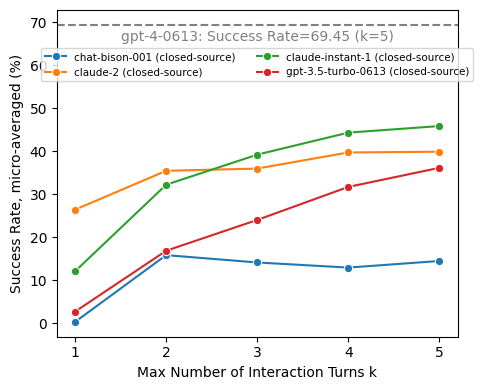

In [ ]:
X_NAME = "Max Number of Interaction Turns k"
Y_NAME = "Success Rate, micro-averaged (%)"
plt.figure(figsize=(5, 4))

# Set color palette
# We run out of colors :(
palette = sns.color_palette()
# palette = sns.color_palette("hls", 21)
# palette = sns.color_palette("Paired", 21)


model_names = pd.DataFrame(sorted(list(interaction_turns["agent_model_name"].unique())), columns=["agent_model_name"])
model_names = model_names[~model_names.agent_model_name.map(is_filtered_model)]
model_names = pd.concat([model_names, model_names["agent_model_name"].apply(parse_modelname).apply(pd.Series)], axis=1)
model_names.sort_values(by=['model', 'size', 'type'], inplace=True)
# agent_model_name -> color
model_names_lst = model_names['agent_model_name'].tolist()

SELECTED_MODEL_LABELS = [
    'gpt-3.5-turbo-0613 (closed-source)',
    'claude-2 (closed-source)',
    'claude-instant-1 (closed-source)',
    'chat-bison-001 (closed-source)',
    'LLaMA-2 (70B, Base)',
    'LLaMA-2 (70B, RLHF)',
    'CodeLlama (34B, Base)',
    'CodeLlama (34B, SIFT)',
    'gpt-4-0613 (closed-source)',
]
cur_color_idx = 0
for agent_model_name, _df in interaction_turns.groupby('agent_model_name'):
    if is_filtered_model(agent_model_name):
        continue

    parsed = parse_modelname(agent_model_name)
    model_name = parsed['model'].replace(r'\texttt{', '').replace('}', '')
    size = parsed['size']
    mtype = parsed['type'][1:]
    label = f"{model_name} ({size}B, {mtype})" if size != "-" else f"{model_name} (closed-source)"

    if label not in SELECTED_MODEL_LABELS:
        continue

    cur_color = palette[cur_color_idx]
    cur_color_idx += 1

    if agent_model_name == 'gpt-4-0613':
        # draw a horizontal line for gpt-4-0613
        _df = _df.query("task_type == 'avg_micro'")
        _x = _df['n_turns'].values
        _y = _df['success_rate'].values
        assert len(_x) == 1 and len(_y) == 1
        plt.axhline(y=_y[0], label="_nolegend_", linestyle='--', color='grey')

        # annotate the line
        plt.annotate(
            f"{agent_model_name}: Success Rate={_y[0]:.2f} (k={_x[0]})",
            xy=(0.5, _y[0] - 6), #-5
            xycoords=('axes fraction', 'data'),
            xytext=(0, 5),
            textcoords='offset points',
            ha='center',
            va='bottom',
            color='grey',
        )
    else:
        _df = _df.query("task_type == 'avg_micro'")
        _x = _df['n_turns'].values
        _y = _df['success_rate'].values
        if not (len(_x) == 5 and len(_y) == 5):
            print(f"WARNING: {agent_model_name} has less than 5 data points")
            continue
        sns.lineplot(
            x=X_NAME,
            y=Y_NAME,
            data=pd.DataFrame({X_NAME: _x, Y_NAME: _y}),
            label=label,
            marker='o',
            dashes=False,
            color=cur_color,
        )

# put legend on upper left
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.90), ncol=2, fontsize=7.5)
plt.xticks([1, 2, 3, 4, 5])
plt.tight_layout()
# plt.savefig("plots/perf-vs-max-turn.pdf", bbox_inches='tight')
plt.show()


### Save website json

In [ ]:
def index_to_name(index):
    model_name, size, model_type = index
    model_name = model_name.replace(r"\texttt{", "").replace("}", "")
    # remove $..$ for model_type
    model_type = re.sub(r"\$.*?\$", "", model_type)

    if size == "-":
        name = f"{model_name} (closed-source)"
    else:
        if "B" not in str(size):
            size = f"{size}B"
        name = f"{model_name} ({size}, {model_type})"
    return name
print("All models:")
for m in list(map(index_to_name, _view.index.tolist())):
    print(f"- {m}")

d = []
for row in _view[[1, 2, 3, 4, 5]].iterrows():
    name = index_to_name(row[0])
    if "gpt-4" in name: continue    
    data = row[1].values.tolist()

    d.append({
        "label": name,
        "data": data,
    })
# print(json.dumps(d, indent=2))
# print("sr_vs_k_series = " + json.dumps(d, indent=2) + ";")
with open("../../website/data/sr_vs_k_series.json", "w") as f:
    json.dump(d, f, indent=2)


All models:
- AgentLM-13b (13B, SIFT)
- AgentLM-70b (70B, SIFT)
- AgentLM-7b (7B, SIFT)
- CodeActAgent-Llama-2-7b (7B, SIFT)
- CodeActAgent-Mistral-7b-v0.1 (7B, SIFT)
- CodeLlama-13b (13B, Base)
- CodeLlama-13b-Instruct (13B, SIFT)
- CodeLlama-34b (34B, Base)
- CodeLlama-34b-Instruct (34B, SIFT)
- CodeLlama-70b-Instruct (70B, SIFT)
- CodeLlama-7b (7B, Base)
- CodeLlama-7b-Instruct (7B, SIFT)
- CodeQwen1.5-7B-Chat (7B, SIFT)
- Eurus-70B-KTO (70B, RLHF)
- Eurus-70B-NCA (70B, RLHF)
- Eurus-70B-SFT (70B, SIFT)
- Eurus-7B-DPO (7B, RLHF)
- Eurus-7B-KTO (7B, RLHF)
- Eurus-7B-NCA (7B, RLHF)
- Eurus-7B-SFT (7B, SIFT)
- Lemur-70b-chat-v1 (70B, SIFT)
- Lemur-70b-v1 (70B, Base)
- Llama-2-13b (13B, Base)
- Llama-2-13b-chat (13B, RLHF)
- Llama-2-70b (70B, Base)
- Llama-2-70b-chat (70B, RLHF)
- Llama-2-7b (7B, Base)
- Llama-2-7b-chat (7B, RLHF)
- MAmmoTH-7B-Mistral (7B, SIFT)
- Magicoder-S-DS-6.7B (6.7B, SIFT)
- Meta-Llama-3-70B-Instruct (70B, RLHF)
- Mistral-7B-Instruct-v0.1 (7B, SIFT)
- Mistral-7B-

In [ ]:
# for later benchmark table aggregation
sr_vs_k_table = _view.copy().drop(columns=["Intercept", "pvalue_Intercept", "pvalue_x"])
sr_vs_k_table.reset_index(inplace=True)
sr_vs_k_table["model"] = sr_vs_k_table["model"].apply(lambda x: x.replace(r"\texttt{", "").replace("}", ""))
sr_vs_k_table.set_index(["model", "size", "type"], inplace=True)
sr_vs_k_table.fillna("-", inplace=True)
sr_vs_k_table.rename(columns={"x": "Slope"}, inplace=True)
sr_vs_k_table.loc[("gpt-4-0613", "-", "-"), "rsquared"] = "-"
sr_vs_k_table.loc[("gpt-4-0613", "-", "-"), "Slope"] = "-"
sr_vs_k_table

/tmp/ipykernel_2889290/1609498971.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  sr_vs_k_table.loc[("gpt-4-0613", "-", "-"), "rsquared"] = "-"
/tmp/ipykernel_2889290/1609498971.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  sr_vs_k_table.loc[("gpt-4-0613", "-", "-"), "Slope"] = "-"


,,,1,2,3,4,5,Slope,rsquared
model,size,type,,,,,,,
AgentLM-13b,13B,SIFT,1.71,7.34,9.22,10.07,10.41,2.013,0.79038
AgentLM-70b,70B,SIFT,6.48,17.75,24.91,28.16,28.67,5.479,0.866144
AgentLM-7b,7B,SIFT,0.0,4.44,5.29,6.48,7.34,1.672,0.856406
CodeActAgent-Llama-2-7b,7B,SIFT,2.56,20.14,26.11,33.62,34.98,7.832,0.887974
CodeActAgent-Mistral-7b-v0.1,7B,SIFT,3.24,26.45,35.15,42.32,44.20,9.779,0.862862
CodeLlama-13b,13B,Base,0.51,13.65,17.92,19.28,18.43,4.147,0.702048
CodeLlama-13b-Instruct,13B,SIFT,1.54,12.63,13.14,15.02,14.51,2.833,0.644487
CodeLlama-34b,34B,Base,0.17,16.21,23.04,25.94,28.16,6.571,0.846121
CodeLlama-34b-Instruct,34B,SIFT,2.56,10.07,14.68,15.36,17.06,3.429,0.858881


## Ability to Leverage Natural Language Feedback (Delta Feedback)

In [ ]:
# generate feedback ablation results (gpt-4-0613)
gpt4_feedback = generate_table(
    "exp_setting == 'max5_p2+tool+cd' and feedback_setting == 'PHF=no_GT-textual' and feedback_model_name == 'gpt-4-0613'",
    mode="sr"
)
print('gpt4 feedback diff')
gpt4_feedback_diff = gpt4_feedback - main_table_sr
display(pd.concat([
    main_table_sr, gpt4_feedback, gpt4_feedback_diff
    ], axis=1, keys=["1SR", "2SR (gpt-4-0613)", "3Diff"]).swaplevel(axis=1).sort_index(axis=1).style.format("{:.2f}").background_gradient(cmap='Blues')
)

# # If you use GPT-3.5 as the feedback model, you will get the following results
# print('gpt35 feedback diff')
# gpt35_feedback = generate_table(
#     "exp_setting == 'max5_p2+tool+cd' and feedback_setting == 'PHF=no_GT-textual' and feedback_model_name == 'gpt-3.5-turbo-16k-0613'",
#     mode=mode,
#     display_table=False,
# )
# gpt35_feedback_diff = gpt35_feedback - main_table_sr
# display(pd.concat([
#     main_table_sr, gpt35_feedback, gpt35_feedback_diff
#     ], axis=1, keys=["SR", "SR (gpt-3.5-turbo-16k-0613)", "Diff"]).swaplevel(axis=1).sort_index(axis=1).style.format("{:.2f}").background_gradient(cmap='Blues')


gpt4 feedback diff


#### Generate LaTeX Table

In [ ]:

def highlight_max(feedback_table):
    w_feedback_perf_max = feedback_table.loc[:, :, :, r"w/ \texttt{GPT-4} feedback"].applymap(lambda x: x.strip("$")).astype(float)
    w_feedback_perf_col_to_sorted_val = {}
    for col in w_feedback_perf_max.columns:
        sorted_val = w_feedback_perf_max[col].sort_values(ascending=False).tolist()
        w_feedback_perf_col_to_sorted_val[col] = sorted_val

    # find the second best
    wo_feedback_perf_max = feedback_table.loc[:, :, :, "no feedback"].applymap(lambda x:  x.strip("$")).astype(float)
    wo_feedback_perf_col_to_sorted_val = {}
    for col in wo_feedback_perf_max.columns:
        sorted_val = wo_feedback_perf_max[col].sort_values(ascending=False).tolist()
        wo_feedback_perf_col_to_sorted_val[col] = sorted_val

    # bold the best and underline the second best
    for row_idx, row in feedback_table.iterrows():
        model, size, mtype, metric = row_idx
        # print(row_idx, row)

        if metric == "no feedback":
            col_to_sorted_val = wo_feedback_perf_col_to_sorted_val
        elif metric == r"w/ \texttt{GPT-4} feedback":
            col_to_sorted_val = w_feedback_perf_col_to_sorted_val
        else:
            # assert metric == "$\Delta_{\texttt{feedback, gpt-4}}$"
            # max_val = diff_max
            continue

        row = row.apply(lambda x: x.strip("$")).astype(float)

        for col_idx, col_val in row.iteritems():
            if col_val == col_to_sorted_val[col_idx][0]:
                feedback_table.loc[row_idx, col_idx] = "$\mathbf{" + f"{col_val:.1f}" + "}$"
            elif col_val == col_to_sorted_val[col_idx][1]:
                feedback_table.loc[row_idx, col_idx] = r"$\underline{" + f"{col_val:.1f}" + "}$"

    return feedback_table

def plot_feedback_diff_table(
    feedback_perf, nofeedback_perf,
    filter_models=[]):
    diff = feedback_perf - nofeedback_perf
    print("feedback diff")
    # display(diff.style.format("{:.2f}").background_gradient(cmap='Blues', axis=0))
    display(
        pd.concat([
            nofeedback_perf,
            feedback_perf,
            diff
        ], axis=1, keys=['1w/o feedback', '2w/ feedback', r'3\Delta_{\text{feedback}}'])
        .style.format("{:.2f}").background_gradient(cmap='Blues', axis=0)
    )
    feedback_table = pd.concat([
        nofeedback_perf.applymap(lambda x: f"${x:.1f}$"),
        feedback_perf.applymap(lambda x: f"${x:.1f}$"),
        diff.applymap(lambda x: "\gcb{" + f"{x:+.1f}" + "}" if float(x) == float(x) else "-")#.applymap(lambda x: "\gcb{" + f"{x:+.2f}" + "}")
    ], axis=1, keys=['1w/o feedback', '2w/ feedback', r'3\Delta_{\text{feedback}}'])

    feedback_table.columns = feedback_table.columns.set_names(['metric', 'task_type'])
    COLUMN_NAME_MAP = {
        "code_generation": "Code Generation",
        "decision_making": "Decision-Making",
        "reasoning": "Reasoning",
        # "vision_language": "Vision-Language",
        "avg_micro": "Micro Average",
    }
    feedback_table = feedback_table.stack(level='metric').rename(columns=COLUMN_NAME_MAP)
    # re-order Micro Average to the last column
    feedback_table = feedback_table.reindex(columns=[
        "Reasoning",
        "Decision-Making",
        "Code Generation",
        # "Vision-Language",
        "Micro Average",
    ])
    feedback_table = feedback_table.reset_index()
    feedback_table = pd.concat([
        pd.DataFrame(feedback_table["agent_model_name"].apply(parse_modelname).tolist()),
        feedback_table
    ], axis=1)
    feedback_table.set_index(["model", "size", "type", "metric"], inplace=True)
    feedback_table.sort_index(inplace=True)
    feedback_table = feedback_table.rename(index={
        "1w/o feedback": "no feedback",
        "2w/ feedback": r"w/ \texttt{GPT-4} feedback",
        r"3\Delta_{\text{feedback}}": r"$\Delta_{\texttt{feedback, gpt-4}}$",
    })
    # display(feedback_table)
    feedback_table.index = feedback_table.index.map(lambda x: (x[0], f"{x[1]}B" if x[1] != "-" else "-", x[2].replace('1', '').replace('2', '').replace('3', ''), x[3]))
    # drop rows with agent_model_name in filter_models
    feedback_table = feedback_table[feedback_table["agent_model_name"].apply(lambda x: x not in filter_models)]
    feedback_table.drop(columns=["agent_model_name"], inplace=True)

    # Bold the best
    CLOSED_SOURCE_MODELS = [
        "chat-bison-001",
        "claude-2",
        "claude-instant-1",
        "gpt-3.5-turbo-0613",
        # "gpt-4-0613" # exclude gpt-4-0613
    ]
    CLOSED_SOURCE_MODELS = [r"\texttt{" + x + "}" for x in CLOSED_SOURCE_MODELS]
    # separate closed source models
    closed_source_table = feedback_table.loc[feedback_table.index.get_level_values("model").isin(CLOSED_SOURCE_MODELS)]
    open_source_table = feedback_table.loc[~feedback_table.index.get_level_values("model").isin(CLOSED_SOURCE_MODELS + [r"\texttt{gpt-4-0613}"])]
    gpt4 = feedback_table.loc[feedback_table.index.get_level_values("model").isin([r"\texttt{gpt-4-0613}"])]
    closed_source_table = highlight_max(closed_source_table)
    open_source_table = highlight_max(open_source_table)

    feedback_table = pd.concat([open_source_table, closed_source_table, gpt4])
    display(feedback_table)

    # # ADD SPECIFIC TAG
    # def add_superscript(index, col, tag):
    #     feedback_table.loc[index, col] = "$^{" + tag + "}" + feedback_table.loc[index, col].lstrip("$")

    # # Not producing desired format
    # add_superscript((r"\texttt{CodeLlama}", "7B", "Base", "no feedback"), "Reasoning", "*")
    # add_superscript((r"\texttt{CodeLlama}", "7B", "Base", "no feedback"), "Code Generation", "*")

    # # CodeLLaMA [PYTHON] issue
    # add_superscript((r"\texttt{CodeLlama}", "13B", "SIFT", "no feedback"), "Code Generation", r"\dagger")
    # add_superscript((r"\texttt{CodeLlama}", "34B", "SIFT", "no feedback"), "Code Generation", r"*\dagger")

    # add_superscript((r"\texttt{LLaMA-2}", "7B", "RLHF", "no feedback"), "Decision-Making", "*")

    # # add_superscript((r"\texttt{Lemur-v1}", "70B", "SIFT", "no feedback"), "Reasoning", "*")
    # # add_superscript((r"\texttt{Lemur-v1}", "70B", "SIFT", "no feedback"), "Decision-Making", "*")
    # # add_superscript((r"\texttt{Lemur-v1}", "70B", "SIFT", "no feedback"), "Code Generation", "*")

    # # vicuna \_ issue
    # add_superscript((r"\texttt{Vicuna-v1.5}", "7B", "SIFT", "no feedback"), "Reasoning", r"\dagger")
    # add_superscript((r"\texttt{Vicuna-v1.5}", "7B", "SIFT", "no feedback"), "Code Generation", r"\dagger")
    # add_superscript((r"\texttt{Vicuna-v1.5}", "13B", "SIFT", "no feedback"), "Reasoning", r"\dagger")
    # add_superscript((r"\texttt{Vicuna-v1.5}", "13B", "SIFT", "no feedback"), "Decision-Making", r"\dagger")
    # add_superscript((r"\texttt{Vicuna-v1.5}", "13B", "SIFT", "no feedback"), "Code Generation", r"\dagger")

    # add_superscript((r"\texttt{chat-bison-001}", "-", "-", "no feedback"), "Reasoning", "*")
    # add_superscript((r"\texttt{chat-bison-001}", "-", "-", "no feedback"), "Code Generation", "*")

    # print latex
    print(feedback_table.to_latex(
        escape=False,
        multirow=True,
        column_format="llllll|l"
    ))
    return feedback_table

gpt4_feedback_sr = generate_table(
    "exp_setting == 'max5_p2+tool+cd' and feedback_setting == 'PHF=no_GT-textual' and feedback_model_name == 'gpt-4-0613'",
    mode='sr'
)
feedback_table = plot_feedback_diff_table(
    gpt4_feedback_sr, main_table_sr,
    filter_models=[
        "vicuna-7b-v1.5-16k",
        "vicuna-13b-v1.5-16k",
        "gpt-3.5-turbo-16k-0613",
        # "CodeLlama-7b",
        # "CodeLlama-13b",
        # "CodeLlama-34b",
        # "Lemur-70b-chat-v1"
    ]
)


feedback diff


/tmp/ipykernel_2889290/1171424215.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feedback_table.loc[row_idx, col_idx] = "$\mathbf{" + f"{col_val:.1f}" + "}$"
/tmp/ipykernel_2889290/1171424215.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feedback_table.loc[row_idx, col_idx] = r"$\underline{" + f"{col_val:.1f}" + "}$"


Reasoning  \
model                       size type metric                                                    
AgentLM-13b                 13B  SIFT no feedback                                       $9.8$   
                                      w/ \texttt{GPT-4} feedback                       $17.4$   
                                      $\Delta_{\texttt{feedback, gpt-4}}$          \gcb{+7.6}   
AgentLM-70b                 70B  SIFT no feedback                                      $27.9$   
                                      w/ \texttt{GPT-4} feedback           $\underline{31.3}$   
...                                                                                       ...   
\texttt{gpt-3.5-turbo-0613} -    -    w/ \texttt{GPT-4} feedback                       $50.3$   
                                      $\Delta_{\texttt{feedback, gpt-4}}$         \gcb{+13.6}   
\texttt{gpt-4-0613}         -    -    no feedback                                      $67.4$   
                                      w/ \texttt{GPT-4} feedback                       $67.1$   
                                      $\Delta_{\texttt{feedback, gpt-4}}$          \gcb{-0.3}   

                                                                           Decision-Making  \
model                       size type metric                                                 
AgentLM-13b                 13B  SIFT no feedback                                   $19.4$   
                                      w/ \texttt{GPT-4} feedback                    $27.6$   
                                      $\Delta_{\texttt{feedback, gpt-4}}$       \gcb{+8.2}   
AgentLM-70b                 70B  SIFT no feedback                                   $46.3$   
                                      w/ \texttt{GPT-4} feedback                    $61.9$   
...                                                                                    ...   
\texttt{gpt-3.5-turbo-0613} -    -    w/ \texttt{GPT-4} feedback           $\mathbf{66.4}$   
                                      $\Delta_{\texttt{feedback, gpt-4}}$      \gcb{+24.6}   
\texttt{gpt-4-0613}         -    -    no feedback                                   $84.3$   
                                      w/ \texttt{GPT-4} feedback                    $85.1$   
                                      $\Delta_{\texttt{feedback, gpt-4}}$       \gcb{+0.7}   

                                                                              Code Generation  \
model                       size type metric                                                    
AgentLM-13b                 13B  SIFT no feedback                                       $2.9$   
                                      w/ \texttt{GPT-4} feedback                        $8.1$   
                                      $\Delta_{\texttt{feedback, gpt-4}}$          \gcb{+5.2}   
AgentLM-70b                 70B  SIFT no feedback                                      $13.2$   
                                      w/ \texttt{GPT-4} feedback           $\underline{31.6}$   
...                                                                                       ...   
\texttt{gpt-3.5-turbo-0613} -    -    w/ \texttt{GPT-4} feedback                       $39.0$   
                                      $\Delta_{\texttt{feedback, gpt-4}}$          \gcb{+9.6}   
\texttt{gpt-4-0613}         -    -    no feedback                                      $59.6$   
                                      w/ \texttt{GPT-4} feedback                       $56.6$   
                                      $\Delta_{\texttt{feedback, gpt-4}}$          \gcb{-2.9}   

                                                                                Micro Average  
model                       size type metric                                                   
AgentLM-13b                 13B  SIFT no feedback                                      $10.4$  
                                      w/ \texttt{

/tmp/ipykernel_2889290/1171424215.py:142: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(feedback_table.to_latex(


\begin{tabular}{llllll|l}
\toprule
                    &   &   &                                     &           Reasoning &     Decision-Making &     Code Generation &       Micro Average \\
model & size & type & metric &                     &                     &                     &                     \\
\midrule
\multirow{3}{*}{AgentLM-13b} & \multirow{3}{*}{13B} & \multirow{3}{*}{SIFT} & no feedback &               $9.8$ &              $19.4$ &               $2.9$ &              $10.4$ \\
                    &   &   & w/ \texttt{GPT-4} feedback &              $17.4$ &              $27.6$ &               $8.1$ &              $17.6$ \\
                    &   &   & $\Delta_{\texttt{feedback, gpt-4}}$ &          \gcb{+7.6} &          \gcb{+8.2} &          \gcb{+5.2} &          \gcb{+7.2} \\
\cline{1-8}
\cline{2-8}
\cline{3-8}
\multirow{3}{*}{AgentLM-70b} & \multirow{3}{*}{70B} & \multirow{3}{*}{SIFT} & no feedback &              $27.9$ &              $46.3$ &              $13.2$ &

### Save Website JSON

In [ ]:
def sr_df_to_json(df):
    sr_json = {
        "avg_micro": [],
        "reasoning": [],
        "decision_making": [],
        "code_generation": [],
    }

    for i, row in df.iterrows():
        agent_model_name = row["agent_model_name"]
        parsed = parse_modelname(agent_model_name)
        parsed["type"] = parsed["type"][1:]
        name = index_to_name((parsed["model"], parsed["size"], parsed["type"]))
        if "16k" in name:
            continue

        for key in sr_json.keys():
            sr_json[key].append([
                name, row[key]
            ])
    return sr_json

_combined_table = pd.concat([main_table_sr, gpt4_feedback], axis=1, keys=["no_feedback", "feedback"]).dropna()

with open("../../website/data/sr_without_feedback.json", "w") as f:
    no_feedback_json = sr_df_to_json(_combined_table["no_feedback"].reset_index())
    json.dump(no_feedback_json, f, indent=2)
with open("../../website/data/sr_with_feedback.json", "w") as f:
    feedback_json = sr_df_to_json(_combined_table["feedback"].reset_index())
    json.dump(feedback_json, f, indent=2)


In [ ]:
sr_w_feedback_table = feedback_table["Micro Average"].unstack().rename(columns={
    r"$\Delta_{\texttt{feedback, gpt-4}}$": "Delta Feedback",
    r"w/ \texttt{GPT-4} feedback": "Success Rate (5 turn) w/ GPT-4 Feedback",
}).drop(columns=["no feedback"]).fillna("-").applymap(lambda x: x.replace("\gcb{", "").replace("}", "").replace("$", "").replace(r"\underline{", "").replace(r"\mathbf{", ""))
sr_w_feedback_table.reset_index(inplace=True)
sr_w_feedback_table["model"] = sr_w_feedback_table["model"].apply(lambda x: x.replace(r"\texttt{", "").replace("}", ""))
sr_w_feedback_table.set_index(["model", "size", "type"], inplace=True)

benchmark_table = pd.concat([sr_vs_k_table, sr_w_feedback_table], axis=1)
# benchmark_table.rename(columns={
#     k: f"{k} turn" for k in [1, 2, 3, 4, 5]
# }).drop(columns=["rsquared", "Slope"])
benchmark_table.reset_index(inplace=True)
# convert everything into float if possible
for col in benchmark_table.columns:
    if col in ["model", "size", "type"]:
        continue
    benchmark_table[col] = benchmark_table[col].apply(lambda x: float(f"{float(x):.2f}") if x != "-" else x)
benchmark_table.to_json("../../website/data/benchmark.json", orient="records", indent=2)


## Efficacy of different LLM in simulating feedback

In [ ]:
def plot_multiple_feedback_diff_table(feedback_perfs, nofeedback_perf, names=[]):

    to_concat = [nofeedback_perf.applymap(lambda x: f"${x:.1f}$")]
    keys = ["1w/o feedback"]
    for i, _feedback_perf in enumerate(feedback_perfs):
        _cur_name = names[i]
        diff = _feedback_perf - nofeedback_perf
        # to_concat.append(_feedback_perf.applymap(lambda x: f"${x:.2f}$"))
        # keys.append(f"{i+2}w/ {_cur_name} feedback")
        to_concat.append(diff.applymap(lambda x: f"${x:+.1f}$"))#.applymap(lambda x: "\gcb{" + f"{x:+.2f}" + "}"))
        # keys.append(str(i+3) + r"$\Delta_\texttt{feedback, "+ _cur_name + "}$")
        keys.append(str(i+3) + r"\texttt{"+ _cur_name + "}")

    feedback_table = pd.concat(
        to_concat, axis=1,
        keys=keys
    )

    # wrap all index with \texttt
    feedback_table.index = feedback_table.index.map(lambda x: "\texttt{" + x + "}")

    feedback_table.columns = feedback_table.columns.set_names(['metric', 'task_type'])
    COLUMN_NAME_MAP = {
        "code_generation": "Code Generation",
        "decision_making": "Decision-Making",
        "reasoning": "Reasoning",
        # "vision_language": "Vision-Language",
        "avg_micro": "Micro Average",
    }
    feedback_table = feedback_table.stack(level='metric').rename(columns=COLUMN_NAME_MAP)
    feedback_table = feedback_table.rename(index={
        k: k[k.find("\\"):] for k in keys
    }) # remove the first character for sorting

    feedback_table = feedback_table.reindex(columns=[
        "Micro Average",
    ])
    # drop the first column
    baseline_perf = main_table_sr.loc["gpt-3.5-turbo-0613"]
    feedback_baseline_perf_gap = []
    for model in names:
        if model not in main_table_sr.index:
            print(f"model {model} not in main_table_sr")
            perf = np.nan
            diff = np.nan
            feedback_baseline_perf_gap.append({"model": model, "gap": diff})
        else:
            perf = main_table_sr.loc[model]
            diff = perf - baseline_perf
            feedback_baseline_perf_gap.append({"model": model, "gap": diff["avg_micro"]})
    feedback_baseline_perf_gap = pd.DataFrame(feedback_baseline_perf_gap).set_index("model")
    feedback_baseline_perf_gap.index = feedback_baseline_perf_gap.index.map(lambda x: r"\texttt{" + x + "}")
    feedback_baseline_perf_gap = feedback_baseline_perf_gap.applymap(lambda x: f"${x:+.1f}$")
    feedback_baseline_perf_gap.reset_index(inplace=True)
    feedback_table = feedback_table.reset_index().drop(columns=["agent_model_name"])
    feedback_table = feedback_table.rename(columns={"metric": "model"})
    feedback_table = pd.merge(feedback_baseline_perf_gap, feedback_table, on="model")
    display(feedback_table)

    # print latex
    print(feedback_table.to_latex(
        index=False,
        escape=False,
        multirow=True,
        column_format="llllll|l"
    ))
    return feedback_table

def get_feedback_model_results(main_table_sr, agent_model_name):
    avail_feedback_models = completed_exp.reset_index().query("agent_model_name == 'gpt-3.5-turbo-0613'")["feedback_model_name"].unique()
    success_rate_tables = []
    names = []
    for feedback_model_name in avail_feedback_models:
        if feedback_model_name == "None":
            continue

        table = generate_table(
            f"exp_setting == 'max5_p2+tool+cd' and feedback_setting == 'PHF=no_GT-textual' and agent_model_name == '{agent_model_name}' and feedback_model_name == '{feedback_model_name}'",
            mode='sr'
        )
        table = table.drop(index=list(
            set(table.index) - {agent_model_name}
        ))
        if table is not None:
            success_rate_tables.append(table)
            names.append(feedback_model_name)
    
    print(f"Feedback model evaluated for {agent_model_name}:")
    for i, name in enumerate(names):
        print(f"- {name}")
    assert len(success_rate_tables) == len(names)
    feedback_efficacy_table = plot_multiple_feedback_diff_table(
        # [
        # gpt4_feedback_sr,
        # gpt35_feedback_sr,
        # claude1_feedback_sr,
        # llama2_70b_base_feedback_sr,
        # llama2_70b_chat_feedback_sr,
        # codellama_34b_base_feedback_sr,
        # codellama_34b_instruct_feedback_sr
        # ],
        success_rate_tables,
        main_table_sr.drop(index=list(
            set(main_table_sr.index) - {agent_model_name}
        )),
        names=names
    )
    return feedback_efficacy_table

feedback_efficacy_table = get_feedback_model_results(main_table_sr, "gpt-3.5-turbo-0613")
# gpt4_feedback_wsr = generate_table("exp_setting == 'max5_p2+tool+cd' and feedback_setting == 'PHF=no_GT-textual' and feedback_model_name == 'gpt-4-0613'", mode='rwp')
# plot_feedback_diff_table(gpt4_feedback_wsr, main_table_wsr)


Feedback model evaluated for gpt-3.5-turbo-0613:
- CodeLlama-34b
- CodeLlama-34b-Instruct
- Llama-2-70b
- Llama-2-70b-chat
- Mistral-7B-Instruct-v0.1
- Mistral-7B-v0.1
- claude-instant-1
- gpt-3.5-turbo-16k-0613
- gpt-4-0613


,model,gap,Micro Average
0,\texttt{CodeLlama-34b},$-8.0$,$+2.4$
1,\texttt{CodeLlama-34b-Instruct},$-19.1$,$+3.2$
2,\texttt{Llama-2-70b},$-9.7$,$-0.5$
3,\texttt{Llama-2-70b-chat},$-18.3$,$-14.0$
4,\texttt{Mistral-7B-Instruct-v0.1},$-22.2$,$-9.4$
5,\texttt{Mistral-7B-v0.1},$-13.8$,$-1.2$
6,\texttt{claude-instant-1},$+9.7$,$+1.5$
7,\texttt{gpt-3.5-turbo-16k-0613},$+4.1$,$-10.4$
8,\texttt{gpt-4-0613},$+33.3$,$+15.2$


\begin{tabular}{llllll|l}
\toprule
                            model &     gap & Micro Average \\
\midrule
           \texttt{CodeLlama-34b} &  $-8.0$ &        $+2.4$ \\
  \texttt{CodeLlama-34b-Instruct} & $-19.1$ &        $+3.2$ \\
             \texttt{Llama-2-70b} &  $-9.7$ &        $-0.5$ \\
        \texttt{Llama-2-70b-chat} & $-18.3$ &       $-14.0$ \\
\texttt{Mistral-7B-Instruct-v0.1} & $-22.2$ &        $-9.4$ \\
         \texttt{Mistral-7B-v0.1} & $-13.8$ &        $-1.2$ \\
        \texttt{claude-instant-1} &  $+9.7$ &        $+1.5$ \\
  \texttt{gpt-3.5-turbo-16k-0613} &  $+4.1$ &       $-10.4$ \\
              \texttt{gpt-4-0613} & $+33.3$ &       $+15.2$ \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2889290/4054557165.py:61: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(feedback_table.to_latex(


### Save Website JSON

In [ ]:
feedback_efficacy_res = feedback_efficacy_table.applymap(lambda x: x.replace("$", '').replace(r"\texttt{", '').replace("}", ''))
d_json = []

for i, row in feedback_efficacy_res.iterrows():
    agent_model_name = row["model"]
    parsed = parse_modelname(agent_model_name)
    parsed["type"] = parsed["type"][1:]
    name = index_to_name((parsed["model"]
                          , parsed["size"], parsed["type"]))

    d_json.append({
        "feedback_provider": name,
        "feedback_provider_info": {
            "model": parsed["model"].replace("\\texttt{", "").replace("}", ""),
            "size": str(parsed["size"]) + "B" if parsed["size"] != "-" else "-",
            "type": parsed["type"] if parsed["type"] else "-",
        },
        "SR5_difference": float(row["gap"]),
        "evaluated_LLM_feedback": float(row["Micro Average"]),
    })

with open("../../website/data/feedback_comparison.json", 'w') as f:
    json.dump(d_json, f, indent=4)


# Ablation Study

## Informativeness of Feedback

#### GT vs NoGT

In [ ]:
def plot_gt_feedback_diff_table(nogt_feedback_perf, gt_feedback_perf, nofeedback_perf):
    diff = gt_feedback_perf - nogt_feedback_perf
    feedback_table = pd.concat([
        nofeedback_perf.applymap(lambda x: f"${x:.2f}$"),
        (nogt_feedback_perf - nofeedback_perf).applymap(lambda x: "\gcb{" + f"{x:+.2f}" + "}"),#.applymap(lambda x: f"${x:.2f}$"),
        (gt_feedback_perf - nofeedback_perf).applymap(lambda x: "\gcb{" + f"{x:+.2f}" + "}"),#.applymap(lambda x: f"${x:.2f}$"),
        diff.applymap(lambda x: "\gcc{" + f"{x:+.2f}" + "}")
    ], axis=1, keys=[
        '1no feedback',
        '2w/o GT',
        '3w/ GT',
        r'4\Delta_{\text{GT feedback}}'
    ])

    # wrap all index with \texttt
    feedback_table.index = feedback_table.index.map(lambda x: "\texttt{" + x + "}")

    feedback_table.columns = feedback_table.columns.set_names(['metric', 'task_type'])
    COLUMN_NAME_MAP = {
        "code_generation": "Code Generation",
        "decision_making": "Decision-Making",
        "reasoning": "Reasoning",
        "vision_language": "Vision-Language",
        "avg_micro": "Micro Average",
    }
    feedback_table = feedback_table.stack(level='metric').rename(columns=COLUMN_NAME_MAP)
    feedback_table = feedback_table.rename(index={
        # "1w/o feedback": "w/o feedback",
        # "2w/ feedback": "w/ feedback",
        # r"3\Delta_{\text{feedback}}": r"$\Delta_{\text{feedback}}$",
        "1no feedback": "no feedback",
        # "2w/o GT": "feedback, w/o GT",
        "2w/o GT": r"$\Delta_{\texttt{feedback, textual, w/o GT}}$",
        # "3w/ GT": "feedback, w/ GT",
        "3w/ GT": r"$\Delta_{\texttt{feedback, textual, w/ GT}}$",
        r"4\Delta_{\text{GT feedback}}": r"$\Delta_{+\text{GT feedback}}$",
    })
    # re-order Micro Average to the last column
    feedback_table = feedback_table.reindex(columns=[
        "Reasoning",
        "Decision-Making",
        "Code Generation",
        # "Vision-Language",
        "Micro Average",
    ])
    feedback_table = feedback_table.reset_index().drop(columns=['agent_model_name'])
    display(feedback_table)

    # print latex
    print(feedback_table.to_latex(
        index=False,
        escape=False,
        multirow=True,
        column_format="llllll|l"
    ))
    return feedback_table


gpt4_nogt_feedback_sr = generate_table(
    "exp_setting == 'max5_p2+tool+cd' and feedback_setting == 'PHF=no_GT-textual' and feedback_model_name == 'gpt-4-0613' and agent_model_name == 'gpt-3.5-turbo-0613'", mode='sr'
)
# gpt4_nogt_feedback_sr.drop(index=["gpt-4-0613"], inplace=True)
gpt4_gt_feedback_sr = generate_table(
    "exp_setting == 'max5_p2+tool+cd' and feedback_setting == 'PHF=GT-textual' and feedback_model_name == 'gpt-4-0613' and agent_model_name == 'gpt-3.5-turbo-0613'", mode='sr'
)
feedback_table = plot_gt_feedback_diff_table(gpt4_nogt_feedback_sr, gpt4_gt_feedback_sr, main_table_sr.drop(index=list(set(main_table_sr.index) - set(gpt4_nogt_feedback_sr.index))))


task_type,metric,Reasoning,Decision-Making,Code Generation,Micro Average
0,no feedback,$36.71$,$41.79$,$29.41$,$36.18$
1,"$\Delta_{\texttt{feedback, textual, w/o GT}}$",\gcb{+13.61},\gcb{+24.63},\gcb{+9.56},\gcb{+15.19}
2,"$\Delta_{\texttt{feedback, textual, w/ GT}}$",\gcb{+16.77},\gcb{-8.95},\gcb{+18.38},\gcb{+11.26}
3,$\Delta_{+\text{GT feedback}}$,\gcc{+3.16},\gcc{-33.58},\gcc{+8.82},\gcc{-3.93}


\begin{tabular}{llllll|l}
\toprule
                                       metric &    Reasoning & Decision-Making & Code Generation & Micro Average \\
\midrule
                                  no feedback &      $36.71$ &         $41.79$ &         $29.41$ &       $36.18$ \\
$\Delta_{\texttt{feedback, textual, w/o GT}}$ & \gcb{+13.61} &    \gcb{+24.63} &     \gcb{+9.56} &  \gcb{+15.19} \\
 $\Delta_{\texttt{feedback, textual, w/ GT}}$ & \gcb{+16.77} &     \gcb{-8.95} &    \gcb{+18.38} &  \gcb{+11.26} \\
               $\Delta_{+\text{GT feedback}}$ &  \gcc{+3.16} &    \gcc{-33.58} &     \gcc{+8.82} &   \gcc{-3.93} \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2889290/3514117525.py:50: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(feedback_table.to_latex(


#### Binary vs. Textual

In [ ]:
def plot_binary_feedback_diff_table(textual_feedback_perf, binary_feedback_perf, nofeedback_perf):
    diff = binary_feedback_perf - textual_feedback_perf
    feedback_table = pd.concat([
        nofeedback_perf.applymap(lambda x: f"${x:.2f}$"),
        (binary_feedback_perf - nofeedback_perf).applymap(lambda x: "\gcb{" + f"{x:+.2f}" + "}"), #.applymap(lambda x: f"${x:.2f}$"),
        (textual_feedback_perf - nofeedback_perf).applymap(lambda x: "\gcb{" + f"{x:+.2f}" + "}"), #.applymap(lambda x: f"${x:.2f}$"),
        diff.applymap(lambda x: "\gcc{" + f"{x:+.2f}" + "}")
    ], axis=1, keys=[
        '1no feedback',
        '2w/ binary feedback',
        '3w/ textual feedback',
        '4\Delta_{\text{textual feedback}}'
    ])

    # wrap all index with \texttt
    feedback_table.index = feedback_table.index.map(lambda x: "\texttt{" + x + "}")

    feedback_table.columns = feedback_table.columns.set_names(['metric', 'task_type'])
    COLUMN_NAME_MAP = {
        "code_generation": "Code Generation",
        "decision_making": "Decision-Making",
        "reasoning": "Reasoning",
        "vision_language": "Vision-Language",
        "avg_micro": "Micro Average",
    }
    feedback_table = feedback_table.stack(level='metric').rename(columns=COLUMN_NAME_MAP)
    feedback_table = feedback_table.rename(index={
        "1no feedback": "No feedback",
        "2w/ binary feedback": r"$\Delta_{\texttt{feedback, binary}}$",
        "3w/ textual feedback": r"$\Delta_{\texttt{feedback, textual}}$",
        "4\Delta_{\text{textual feedback}}": r"$\Delta_{-\text{textual feedback}}$",
    })
    # re-order Micro Average to the last column
    feedback_table = feedback_table.reindex(columns=[
        "Reasoning",
        "Decision-Making",
        "Code Generation",
        # "Vision-Language",
        "Micro Average",
    ])
    feedback_table = feedback_table.reset_index().drop(columns=['agent_model_name'])
    display(feedback_table)

    # print latex
    print(feedback_table.to_latex(
        index=False,
        escape=False,
        multirow=True,
        column_format="ll|lll|l"
    ))
    return feedback_table


gpt4_textual_feedback_sr = generate_table(
    "exp_setting == 'max5_p2+tool+cd' and feedback_setting == 'PHF=no_GT-textual' and feedback_model_name == 'gpt-4-0613' and agent_model_name == 'gpt-3.5-turbo-0613'", mode='sr'
)
gpt4_binary_feedback_sr = generate_table(
    "exp_setting == 'max5_p2+tool+cd' and feedback_setting == 'PHF=no_GT-binary' and feedback_model_name == 'gpt-4-0613' and agent_model_name == 'gpt-3.5-turbo-0613'", mode='sr'
)
# remove index that is in dense feedback but not in sparse feedback
gpt4_textual_feedback_sr.drop(index=list(set(gpt4_textual_feedback_sr.index) - set(gpt4_binary_feedback_sr.index)), inplace=True)
feedback_table = plot_binary_feedback_diff_table(
    gpt4_textual_feedback_sr,
    gpt4_binary_feedback_sr,
    main_table_sr.drop(index=list(set(main_table_sr.index) - set(gpt4_textual_feedback_sr.index)))
)


task_type,metric,Reasoning,Decision-Making,Code Generation,Micro Average
0,No feedback,$36.71$,$41.79$,$29.41$,$36.18$
1,"$\Delta_{\texttt{feedback, binary}}$",\gcb{+2.21},\gcb{+5.97},\gcb{+0.74},\gcb{+2.73}
2,"$\Delta_{\texttt{feedback, textual}}$",\gcb{+13.61},\gcb{+24.63},\gcb{+9.56},\gcb{+15.19}
3,$\Delta_{-\text{textual feedback}}$,\gcc{-11.40},\gcc{-18.66},\gcc{-8.82},\gcc{-12.46}


\begin{tabular}{ll|lll|l}
\toprule
                               metric &    Reasoning & Decision-Making & Code Generation & Micro Average \\
\midrule
                          No feedback &      $36.71$ &         $41.79$ &         $29.41$ &       $36.18$ \\
 $\Delta_{\texttt{feedback, binary}}$ &  \gcb{+2.21} &     \gcb{+5.97} &     \gcb{+0.74} &   \gcb{+2.73} \\
$\Delta_{\texttt{feedback, textual}}$ & \gcb{+13.61} &    \gcb{+24.63} &     \gcb{+9.56} &  \gcb{+15.19} \\
  $\Delta_{-\text{textual feedback}}$ & \gcc{-11.40} &    \gcc{-18.66} &     \gcc{-8.82} &  \gcc{-12.46} \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2889290/1831033079.py:45: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(feedback_table.to_latex(


## Frequency of Feedback

In [ ]:
def plot_sparse_feedback_diff_table(dense_feedback_perf, sparse_feedback_perf, nofeedback_perf):
    diff = sparse_feedback_perf - dense_feedback_perf
    feedback_table = pd.concat([
        nofeedback_perf.applymap(lambda x: f"${x:.2f}$"),
        (dense_feedback_perf - nofeedback_perf).applymap(lambda x: "\gcb{" + f"{x:+.2f}" + "}"), #.applymap(lambda x: f"${x:.2f}$"),
        (sparse_feedback_perf - nofeedback_perf).applymap(lambda x: "\gcb{" + f"{x:+.2f}" + "}"), #.applymap(lambda x: f"${x:.2f}$"),
        diff.applymap(lambda x: "\gcc{" + f"{x:+.2f}" + "}")
    ], axis=1, keys=[
        '1no feedback',
        '2w/ dense feedback',
        '3w/ sparse feedback',
        '4\Delta_{\text{feedback frequency}}'
    ])

    # wrap all index with \texttt
    feedback_table.index = feedback_table.index.map(lambda x: "\texttt{" + x + "}")

    feedback_table.columns = feedback_table.columns.set_names(['metric', 'task_type'])
    COLUMN_NAME_MAP = {
        "code_generation": "Code Generation",
        "decision_making": "Decision-Making",
        "reasoning": "Reasoning",
        "vision_language": "Vision-Language",
        "avg_micro": "Micro Average",
    }
    feedback_table = feedback_table.stack(level='metric').rename(columns=COLUMN_NAME_MAP)
    feedback_table = feedback_table.rename(index={
        "1no feedback": "No feedback",
        "2w/ dense feedback": r"\Delta_{\texttt{feedback, dense}}",
        "3w/ sparse feedback": r"\Delta_{\texttt{feedback, sparse}}",
        "4\Delta_{\text{feedback frequency}}": r"$\Delta_{-\text{feedback frequency}}$",
    })
    # re-order Micro Average to the last column
    feedback_table = feedback_table.reindex(columns=[
        "Reasoning",
        "Decision-Making",
        "Code Generation",
        # "Vision-Language",
        "Micro Average",
    ])
    feedback_table = feedback_table.reset_index().drop(columns=['agent_model_name'])
    display(feedback_table)

    # print latex
    print(feedback_table.to_latex(
        index=False,
        escape=False,
        multirow=True,
        column_format="ll|lll|l"
    ))
    return feedback_table


gpt4_dense_feedback_sr = generate_table(
    "exp_setting == 'max5_p2+tool+cd' and feedback_setting == 'PHF=no_GT-textual' and feedback_model_name == 'gpt-4-0613' and agent_model_name == 'gpt-3.5-turbo-0613'", mode='sr'
)
gpt4_sparse_feedback_sr = generate_table(
    "exp_setting == 'max5_p2+tool+cd' and feedback_setting == 'PHF=no_GT-textual-sparse' and feedback_model_name == 'gpt-4-0613' and agent_model_name == 'gpt-3.5-turbo-0613'", mode='sr'
)
# remove index that is in dense feedback but not in sparse feedback
gpt4_dense_feedback_sr.drop(index=list(set(gpt4_dense_feedback_sr.index) - set(gpt4_sparse_feedback_sr.index)), inplace=True)
feedback_table = plot_sparse_feedback_diff_table(
    gpt4_dense_feedback_sr,
    gpt4_sparse_feedback_sr,
    main_table_sr.drop(index=list(set(main_table_sr.index) - set(gpt4_dense_feedback_sr.index)))
)


task_type,metric,Reasoning,Decision-Making,Code Generation,Micro Average
0,No feedback,$36.71$,$41.79$,$29.41$,$36.18$
1,"\Delta_{\texttt{feedback, dense}}",\gcb{+13.61},\gcb{+24.63},\gcb{+9.56},\gcb{+15.19}
2,"\Delta_{\texttt{feedback, sparse}}",\gcb{+5.38},\gcb{+4.48},\gcb{+0.74},\gcb{+4.09}
3,$\Delta_{-\text{feedback frequency}}$,\gcc{-8.23},\gcc{-20.15},\gcc{-8.82},\gcc{-11.10}


\begin{tabular}{ll|lll|l}
\toprule
                               metric &    Reasoning & Decision-Making & Code Generation & Micro Average \\
\midrule
                          No feedback &      $36.71$ &         $41.79$ &         $29.41$ &       $36.18$ \\
    \Delta_{\texttt{feedback, dense}} & \gcb{+13.61} &    \gcb{+24.63} &     \gcb{+9.56} &  \gcb{+15.19} \\
   \Delta_{\texttt{feedback, sparse}} &  \gcb{+5.38} &     \gcb{+4.48} &     \gcb{+0.74} &   \gcb{+4.09} \\
$\Delta_{-\text{feedback frequency}}$ &  \gcc{-8.23} &    \gcc{-20.15} &     \gcc{-8.82} &  \gcc{-11.10} \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2889290/1977340069.py:45: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(feedback_table.to_latex(


## Detected Issues

In [ ]:
def get_assistant_traj_str(state):
    traj_str = ""
    history = state["history"]
    for d in history:
        if d["role"] == "assistant":
            traj_str += f"\n{d['content']}\n"
    return traj_str


### Why Some Numbers are Zero? Fraction of Invalid Format

In [ ]:
def replace_index(df):
    df = pd.concat([
        pd.DataFrame(pd.Series(df.index).apply(parse_modelname).tolist()),
        df.reset_index(drop=True)
    ], axis=1)
    df.set_index(["model", "size", "type"], inplace=True)
    df.sort_index(inplace=True)
    df.index = df.index.map(lambda x: (x[0], f"{x[1]}B" if x[1] != "-" else "-", x[2].replace('1', '').replace('2', '').replace('3', '')))
    return df


avg_count = generate_table("exp_setting == 'max5_p2+tool+cd' and feedback_setting == 'None' and feedback_model_name == 'None'", mode='invalid_count')
filter_models=[
    "vicuna-7b-v1.5-16k",
    "vicuna-13b-v1.5-16k",
    "gpt-3.5-turbo-16k-0613",
    "gpt-3.5-turbo-0613-human-eval-gpt",
    "gpt-3.5-turbo-0613-human-eval-human",
    # "Lemur-70b-chat-v1"
]
display(avg_count[["invalid_count", "n_turns"]].style.format("{:.2f}").background_gradient(cmap='Blues', axis=0))
avg_count.reset_index(inplace=True)
avg_count = avg_count[avg_count["agent_model_name"].apply(lambda x: x not in filter_models)]
avg_count.set_index(["agent_model_name"], inplace=True)


# merge the two tables
avg_count_table = avg_count["invalid_count"].applymap(lambda x: f"{x:.2f}") + avg_count["n_turns"].applymap(lambda x: f" / {x:.2f}")
def _bold_ratio(x, ratio=0.2):
    ele1, ele2 = x.split(" / ")
    ele1 = float(ele1)
    ele2 = float(ele2)
    if (ele1 / (ele2+1e-6)) > ratio:
        return "$\mathbf{" + f"{ele1:.2f}" + "}$ / $\mathbf{" + f"{ele2:.2f}" + "}$"
    else:
        return "$" + f"{ele1:.2f}" + "$ / $" + f"{ele2:.2f}" + "$"
avg_count_table = avg_count_table.applymap(_bold_ratio)

avg_count_table = replace_index(avg_count_table)[["reasoning", "decision_making", "code_generation", "avg_micro"]]
display(avg_count_table)
print(avg_count_table.to_latex(
    escape=False,
    multirow=True,
    column_format="l|llll|l"
))


,,,reasoning,decision_making,code_generation,avg_micro
model,size,type,,,,
AgentLM-13b,13B,SIFT,$\mathbf{1.55}$ / $\mathbf{4.11}$,$\mathbf{1.46}$ / $\mathbf{4.27}$,$0.54$ / $4.25$,$\mathbf{1.29}$ / $\mathbf{4.18}$
AgentLM-70b,70B,SIFT,$0.35$ / $3.58$,$0.01$ / $3.54$,$0.07$ / $3.99$,$0.21$ / $3.66$
AgentLM-7b,7B,SIFT,$\mathbf{1.71}$ / $\mathbf{4.25}$,$\mathbf{1.85}$ / $\mathbf{4.69}$,$0.89$ / $4.69$,$\mathbf{1.55}$ / $\mathbf{4.46}$
CodeActAgent-Llama-2-7b,7B,SIFT,$0.15$ / $4.00$,$0.00$ / $2.84$,$0.08$ / $3.54$,$0.10$ / $3.63$
CodeActAgent-Mistral-7b-v0.1,7B,SIFT,$0.11$ / $4.03$,$0.02$ / $2.89$,$0.10$ / $3.55$,$0.09$ / $3.66$
CodeLlama-13b,13B,Base,$0.50$ / $4.55$,$0.00$ / $3.36$,$0.00$ / $4.93$,$0.27$ / $4.36$
CodeLlama-13b-Instruct,13B,SIFT,$0.16$ / $4.66$,$0.01$ / $3.77$,$0.04$ / $4.77$,$0.10$ / $4.48$
CodeLlama-34b,34B,Base,$0.19$ / $4.21$,$0.00$ / $3.37$,$0.05$ / $4.77$,$0.11$ / $4.15$
CodeLlama-34b-Instruct,34B,SIFT,$0.23$ / $3.68$,$0.04$ / $3.83$,$\mathbf{1.09}$ / $\mathbf{3.27}$,$0.39$ / $3.62$


\begin{tabular}{l|llll|l}
\toprule
               &    &      &                          reasoning &                    decision_making &                    code_generation &                          avg_micro \\
model & size & type &                                    &                                    &                                    &                                    \\
\midrule
AgentLM-13b & 13B & SIFT &  $\mathbf{1.55}$ / $\mathbf{4.11}$ &  $\mathbf{1.46}$ / $\mathbf{4.27}$ &                    $0.54$ / $4.25$ &  $\mathbf{1.29}$ / $\mathbf{4.18}$ \\
AgentLM-70b & 70B & SIFT &                    $0.35$ / $3.58$ &                    $0.01$ / $3.54$ &                    $0.07$ / $3.99$ &                    $0.21$ / $3.66$ \\
AgentLM-7b & 7B & SIFT &  $\mathbf{1.71}$ / $\mathbf{4.25}$ &  $\mathbf{1.85}$ / $\mathbf{4.69}$ &                    $0.89$ / $4.69$ &  $\mathbf{1.55}$ / $\mathbf{4.46}$ \\
CodeActAgent-Llama-2-7b & 7B & SIFT &                    $0.15$ / $4.00$ &       

/tmp/ipykernel_2889290/1926447918.py:41: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(avg_count_table.to_latex(


### Vicuna Escaped Underscore

In [ ]:
escape_underscore_results = all_results.query("exp_setting == 'max5_p2+tool+cd' and feedback_setting == 'None' and feedback_model_name == 'None'")

escape_underscore_count = escape_underscore_results["state"].apply(get_assistant_traj_str).apply(lambda x: x.count(r"\_") > 0)
escape_underscore_count = pd.concat([escape_underscore_results[["agent_model_name", "task_type"]], escape_underscore_count], axis=1)
escape_underscore_count = escape_underscore_count.groupby(["agent_model_name", "task_type"]).mean() * 100
escape_underscore_count.reset_index(inplace=True)

escape_underscore_count = pd.concat([
    pd.DataFrame(escape_underscore_count["agent_model_name"].apply(parse_modelname).tolist()),
    escape_underscore_count
], axis=1)
escape_underscore_count.set_index(["model", "size", "type", "task_type"], inplace=True)
escape_underscore_count.drop(columns=["agent_model_name"], inplace=True)
escape_underscore_count = escape_underscore_count.unstack()["state"]
escape_underscore_count.sort_index(inplace=True)
escape_underscore_count.index = escape_underscore_count.index.map(lambda x: 
    (x[0], f"{x[1]}B" if x[1] != "-" else "-", x[2].replace('1', '').replace('2', '').replace('3', ''))
)
escape_underscore_count = escape_underscore_count[["reasoning", "decision_making", "code_generation"]]
display(escape_underscore_count.style.background_gradient(cmap='Blues', axis=0))

escape_underscore_count = escape_underscore_count.applymap(lambda x: f"${x:.2f}$" if x < 2 else f"$\\mathbf{{{x:.2f}}}$")


print(escape_underscore_count.to_latex(
    escape=False,
    multirow=True,
    column_format="l|l",
    float_format="%.2f"
))


,,task_type,reasoning,decision_making,code_generation
model,size,type,,,
AgentLM-13b,13B,SIFT,8.544304,0.000000,14.705882
AgentLM-70b,70B,SIFT,6.329114,0.746269,6.617647
AgentLM-7b,7B,SIFT,11.392405,0.000000,8.823529
CodeActAgent-Llama-2-7b,7B,SIFT,0.000000,0.000000,0.000000
CodeActAgent-Mistral-7b-v0.1,7B,SIFT,0.000000,0.000000,0.000000
CodeLlama-13b,13B,Base,0.000000,0.000000,0.000000
CodeLlama-13b-Instruct,13B,SIFT,0.000000,0.000000,0.000000
CodeLlama-34b,34B,Base,0.000000,0.000000,0.000000
CodeLlama-34b-Instruct,34B,SIFT,0.000000,0.000000,0.000000


\begin{tabular}{l|l}
\toprule
               &    & task_type &         reasoning &   decision_making &   code_generation \\
model & size & type &                   &                   &                   \\
\midrule
AgentLM-13b & 13B & SIFT &   $\mathbf{8.54}$ &            $0.00$ &  $\mathbf{14.71}$ \\
AgentLM-70b & 70B & SIFT &   $\mathbf{6.33}$ &            $0.75$ &   $\mathbf{6.62}$ \\
AgentLM-7b & 7B & SIFT &  $\mathbf{11.39}$ &            $0.00$ &   $\mathbf{8.82}$ \\
CodeActAgent-Llama-2-7b & 7B & SIFT &            $0.00$ &            $0.00$ &            $0.00$ \\
CodeActAgent-Mistral-7b-v0.1 & 7B & SIFT &            $0.00$ &            $0.00$ &            $0.00$ \\
CodeLlama-13b & 13B & Base &            $0.00$ &            $0.00$ &            $0.00$ \\
CodeLlama-13b-Instruct & 13B & SIFT &            $0.00$ &            $0.00$ &            $0.00$ \\
CodeLlama-34b & 34B & Base &            $0.00$ &            $0.00$ &            $0.00$ \\
CodeLlama-34b-Instruct & 34B & SIFT &  

/tmp/ipykernel_2889290/153345448.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(escape_underscore_count.to_latex(


### CodeLLaMA `\[PYTHON\]` bug

In [ ]:
python_bracket_results = all_results.query("exp_setting == 'max5_p2+tool+cd' and feedback_setting == 'None' and feedback_model_name == 'None'")

python_bracket_count = python_bracket_results["state"].apply(get_assistant_traj_str).apply(lambda x: x.count(r"[PYTHON]") > 0)
python_bracket_count = pd.concat([python_bracket_results[["agent_model_name", "task_type"]], python_bracket_count], axis=1)
python_bracket_count = python_bracket_count.groupby(["agent_model_name", "task_type"]).mean() * 100
python_bracket_count.reset_index(inplace=True)

python_bracket_count = pd.concat([
    pd.DataFrame(python_bracket_count["agent_model_name"].apply(parse_modelname).tolist()),
    python_bracket_count
], axis=1)
python_bracket_count.set_index(["model", "size", "type", "task_type"], inplace=True)
python_bracket_count.drop(columns=["agent_model_name"], inplace=True)
python_bracket_count = python_bracket_count.unstack()["state"]
python_bracket_count.sort_index(inplace=True)
python_bracket_count.index = python_bracket_count.index.map(lambda x: 
    (x[0], f"{x[1]}B" if x[1] != "-" else "-", x[2].replace('1', '').replace('2', '').replace('3', ''))
)
python_bracket_count = python_bracket_count[["reasoning", "decision_making", "code_generation"]]
display(python_bracket_count.style.background_gradient(cmap='Blues', axis=0))
python_bracket_count = python_bracket_count.applymap(lambda x: f"${x:.2f}$" if x < 2 else f"$\\mathbf{{{x:.2f}}}$")

print(python_bracket_count.to_latex(
    escape=False,
    multirow=True,
    column_format="l|l",
    float_format="%.2f"
))


,,task_type,reasoning,decision_making,code_generation
model,size,type,,,
AgentLM-13b,13B,SIFT,0.000000,0.000000,0.000000
AgentLM-70b,70B,SIFT,0.000000,0.000000,0.000000
AgentLM-7b,7B,SIFT,0.000000,0.000000,0.000000
CodeActAgent-Llama-2-7b,7B,SIFT,0.000000,0.000000,0.000000
CodeActAgent-Mistral-7b-v0.1,7B,SIFT,0.000000,0.000000,0.000000
CodeLlama-13b,13B,Base,0.000000,0.000000,0.000000
CodeLlama-13b-Instruct,13B,SIFT,0.000000,0.000000,2.205882
CodeLlama-34b,34B,Base,0.000000,0.000000,0.000000
CodeLlama-34b-Instruct,34B,SIFT,0.000000,0.000000,100.000000


\begin{tabular}{l|l}
\toprule
               &    & task_type & reasoning & decision_making &    code_generation \\
model & size & type &           &                 &                    \\
\midrule
AgentLM-13b & 13B & SIFT &    $0.00$ &          $0.00$ &             $0.00$ \\
AgentLM-70b & 70B & SIFT &    $0.00$ &          $0.00$ &             $0.00$ \\
AgentLM-7b & 7B & SIFT &    $0.00$ &          $0.00$ &             $0.00$ \\
CodeActAgent-Llama-2-7b & 7B & SIFT &    $0.00$ &          $0.00$ &             $0.00$ \\
CodeActAgent-Mistral-7b-v0.1 & 7B & SIFT &    $0.00$ &          $0.00$ &             $0.00$ \\
CodeLlama-13b & 13B & Base &    $0.00$ &          $0.00$ &             $0.00$ \\
CodeLlama-13b-Instruct & 13B & SIFT &    $0.00$ &          $0.00$ &    $\mathbf{2.21}$ \\
CodeLlama-34b & 34B & Base &    $0.00$ &          $0.00$ &             $0.00$ \\
CodeLlama-34b-Instruct & 34B & SIFT &    $0.00$ &          $0.00$ &  $\mathbf{100.00}$ \\
CodeLlama-70b-Instruct & 70B & SIFT &  

/tmp/ipykernel_2889290/1094553505.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(python_bracket_count.to_latex(
